# 라이브러리 및 데이터

In [ ]:
import pandas as pd
import numpy as np
import math

#시각화
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps
from matplotlib import patches as mpatches
import matplotlib.cm as cm
import folium

#전처리
from sklearn.preprocessing import StandardScaler

#모델링
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

#한글폰트 설정
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
    font_name = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    font_name = 'AppleGothic'
else:  # Linux
    font_name = 'NanumGothic'

rc('font', family=font_name)

plt.rcParams['axes.unicode_minus'] = False
print(plt.rcParams['font.family'])

['Malgun Gothic']


라이브러리가 존재하지 않은 경우 해당 패키지를 설치한다

In [ ]:
# pip install pandas
# pip install numpy
# pip install math

# pip install matplotlib
# pip install seaborn
# pip install folium

# pip install scikit-learn
# pip install yellowbrick
# pip install factor_analyzer

### 1) 민간데이터

신한카드에서 제공한 민간데이터는 보안서약서에 의거, 분석 후 파기하여 Github에 데이터를 저장하지 않았다.  
따라서 아래의 민간데이터를 불러오는 코드는 작동하지 않아 참조처리하였다.  
따라서 민간데이터와 관련된 분석 및 시각화 코드도 전부 참조처리를 진행하였다

In [ ]:
# chunksize = 10000  # 1만 줄씩 읽기

# chunks = pd.read_csv("../사용데이터/읍면동_시간대별_카드_개인_2023.csv", chunksize=chunksize, encoding='utf-8-sig')
# df_list_2023 = []
# for chunk in chunks:
#     df_list_2023.append(chunk)
# data_2023 = pd.concat(df_list_2023, ignore_index=True)

# chunks = pd.read_csv("../사용데이터/읍면동_시간대별_카드_개인_2024.csv", chunksize=chunksize, encoding='utf-8-sig')
# df_list_2024 = []
# for chunk in chunks:
#     df_list_2024.append(chunk)
# data_2024 = pd.concat(df_list_2024, ignore_index=True)

### 2) 성남사랑상품권 데이터

In [11]:
data1=pd.read_csv("../사용데이터/지역상품권_분당.csv", encoding="utf-8-sig")
data2=pd.read_csv("../사용데이터/지역상품권_수정.csv", encoding="utf-8-sig")
data3=pd.read_csv("../사용데이터/지역상품권_중원.csv", encoding="utf-8-sig")

data_gift=pd.concat([data1, data2, data3], ignore_index=True, axis=0)
data_gift.sort_values(by="crtr_ym", inplace=True)
data_gift['crtr_ym'] = pd.to_datetime(data_gift['crtr_ym'], format='%Y%m')
data_gift.replace({"usage_rgn_cd":{41135:"분당구", 41133:"중원구", 41131:"수정구"}}, inplace=True)

## 3) 분석용 데이터셋

### '분당구_2024년 2분기_상권별_업종_매출_비율데이터.csv'

In [13]:
data_big_original=pd.read_csv("../사용데이터/분당구_2024년2분기_상권별_업종_매출_비율데이터.csv", encoding="utf-8-sig")
data_big=data_big_original.copy() #데이터 분석용

## 4) 공간시각화용 분당구 상권 좌표 데이터

In [14]:
location=pd.read_csv("../사용데이터/bundang_store_location.csv", encoding="utf-8-sig")

## 5) 지역상권 매출 특징 데이터

In [2]:
data_day=pd.read_csv("../사용데이터/성남 요일별_최종.csv",encoding='cp949')
data_time=pd.read_csv("../사용데이터/성남 시간별_최종.csv",encoding='cp949')
data_age_sex=pd.read_csv("../사용데이터/성남 연령대별 성별_최종.csv",encoding='cp949')

data_small=pd.read_csv("../사용데이터/상권별_업종소분류_점포수_매출_2021년제거.csv",encoding='utf-8-sig')
data_small=data_small.melt(id_vars=["성남상권","상권종류","분기","매출총액","매출건수","상권명"], var_name="업종", value_name="점포수")
data_small["업종대분류"] = np.where(
    data_small["업종"].isin(['여관업', '민박업', '기숙사ㆍ고시원', '그 외 기타 숙박', '부동산 중개업', '일반 교과학원',
       '방문 교육학원', '태권도ㆍ무술학원', '기타 스포츠 학원', '청소년 수련시설', '음악학원', '미술학원',
       '기타 예술학원', '외국어학원', '기타 교습학원', '일반의원', '치과의원', '한의원', '체력 단련시설',
       '당구장', '골프 연습장', '컴퓨터 게임방', '노래 연습장', '자동차 수리', '자동차 세차',
       '가전제품 수리', '두발 미용', '피부 미용', '기타 미용', '가정용세탁']), "서비스업",
    np.where(data_small["업종"].isin(['슈퍼마켓', '편의점', '기타 음ㆍ식료품', '곡물ㆍ곡분ㆍ사료', '육류', '건어물ㆍ젓갈류',
       '신선ㆍ냉동ㆍ수산물', '채소과일', '건강보조식품', '조리반찬', '기타 식료품', '컴퓨터ㆍ주변장치', '핸드폰',
       '가전제품', '남자의류', '여자의류', '속옷ㆍ잠옷', '의류 상의', '가죽 및 모피 의복', '기타 의복',
       '가정용 직물제품', '의복 액세서리ㆍ장신구', '섬유제품', '신발', '가방ㆍ기타 가죽', '철물ㆍ난방용구',
       '벽지ㆍ마루ㆍ장판류', '페인트ㆍ창호ㆍ건설자재', '가구', '전기ㆍ조명', '주방ㆍ가정유리ㆍ요업', '기타 가정용품',
       '서적ㆍ신문ㆍ잡지류', '문구ㆍ회화용품', '운동ㆍ경기용품', '자전거ㆍ운송장비', '게임ㆍ인형ㆍ장난감',
       '의약품ㆍ의료용품', '의료용 기구', '화장품ㆍ비누ㆍ방향제', '안경ㆍ렌즈', '시계ㆍ귀금속', '화초ㆍ식물',
       '애완동물ㆍ관련용품', '전자상거래 중개(소매)', '전자상거래(소매)']), "소매업", "음식업")
)

# 1.분석 배경 및 목표

### <그림 3,성남시 분당구 연령대별 카드이용 금액의 합계>

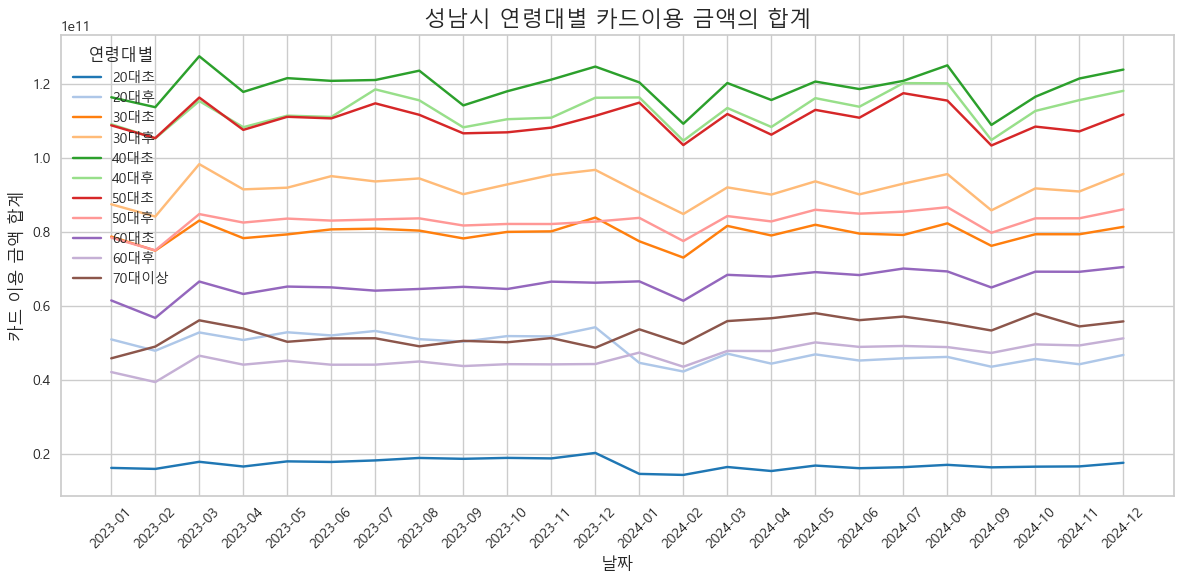

In [ ]:
# #시각화용 데이터 전처리
# temp_2023=data_2023[["기준일자",'읍면동',"연령대별","카드이용금액_sum"]].copy()
# temp_2023['기준일자'] = temp_2023['기준일자'].astype(int).copy()
# temp_2023['기준일자'] = temp_2023['기준일자'].astype(str).copy()
# temp_2023['기준일자'] = pd.to_datetime(temp_2023['기준일자'], format='%Y%m%d').copy()
# temp_2023['month'] = temp_2023['기준일자'].dt.to_period('M').astype(str) #월 정보 추출
# result_2023=temp_2023.groupby(['month', '연령대별'], as_index=False)['카드이용금액_sum'].sum().rename(columns={'amount': 'sum_amount'})

# temp_2024=data_2024[["기준일자",'읍면동',"연령대별","카드이용금액_sum"]].copy()
# temp_2024['기준일자'] = temp_2024['기준일자'].astype(int).copy()
# temp_2024['기준일자'] = temp_2024['기준일자'].astype(str).copy()
# temp_2024['기준일자'] = pd.to_datetime(temp_2024['기준일자'], format='%Y%m%d').copy()
# temp_2024['month'] = temp_2024['기준일자'].dt.to_period('M').astype(str) #월 정보 추출
# result_2024=temp_2024.groupby(['month', '연령대별'], as_index=False)['카드이용금액_sum'].sum().rename(columns={'amount': 'sum_amount'})

# #시각화용 데이터
# result=pd.concat([result_2023, result_2024], ignore_index=True)

# #시각화
# sns.set_palette("tab20")
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=result, x='month', y='카드이용금액_sum', hue='연령대별')
# plt.xticks(rotation=45)
# plt.title('성남시 연령대별 카드이용 금액의 합계', fontsize=16)
# plt.xlabel('날짜', fontsize=12)
# plt.ylabel('카드 이용 금액 합계', fontsize=12)
# plt.legend(title='연령대별', loc='upper left')
# plt.tight_layout()
# plt.show()

### <그림 4, 성남사랑 상품권 연령대별 결제횟수와 객단가 변화>

In [15]:
temp1_2023=data_gift[data_gift['crtr_ym'] >= '2023-01-01'].reset_index(drop=True)

temp1 = temp1_2023[["crtr_ym", "par_ag", "stlm_amt", "stlm_nocs"]].reset_index(drop=True).copy()
temp1 = temp1.groupby(["crtr_ym","par_ag"]).agg({"stlm_amt": "sum", "stlm_nocs": "sum"}).reset_index()
temp1["객단가"]=temp1["stlm_amt"]/temp1["stlm_nocs"]
temp1.replace({"par_ag":{1:"10대",
                         2:"20대",
                         3:"30대",
                         4:"40대",
                         5:"50대",
                         6:"60대 이상"}}, inplace=True)

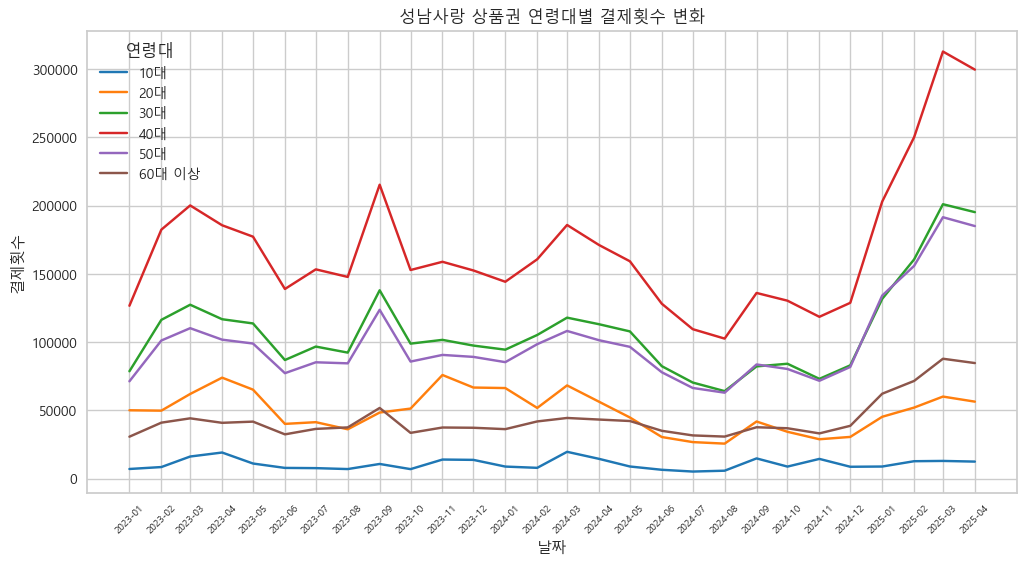

In [16]:
plt.figure(figsize=(12, 6))

color_mapping = {
    "10대": "#1f77b4",
    "20대": "#ff7f0e",
    "30대": "#2ca02c",
    "40대": "#d62728",
    "50대": "#9467bd",
    "60대 이상": "#8c564b"
}
x_order = sorted(temp1["crtr_ym"].unique())
x_labels = [d.strftime('%Y-%m') for d in x_order]

for age_group in temp1['par_ag'].unique():
    subset = temp1[temp1['par_ag'] == age_group]
    plt.plot(subset['crtr_ym'], subset['stlm_nocs'], label=f'{age_group}', color=color_mapping[age_group])

plt.xlabel('날짜')
plt.ylabel('결제횟수')
plt.title('성남사랑 상품권 연령대별 결제횟수 변화')
plt.legend(title='연령대', loc='upper left')
plt.xticks(ticks=x_order, labels=x_labels, rotation=45, fontsize=7)
plt.grid(True)
plt.show()


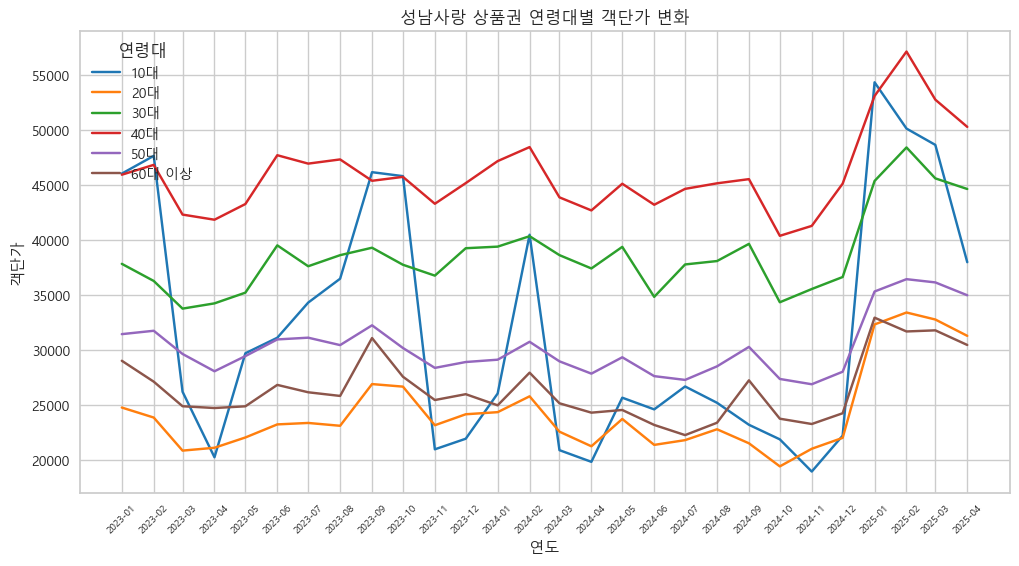

In [17]:
plt.figure(figsize=(12, 6))

color_mapping = {
    "10대": "#1f77b4",
    "20대": "#ff7f0e",
    "30대": "#2ca02c",
    "40대": "#d62728",
    "50대": "#9467bd",
    "60대 이상": "#8c564b"
}
x_order = sorted(temp1["crtr_ym"].unique())
x_labels = [d.strftime('%Y-%m') for d in x_order]

for age_group in temp1['par_ag'].unique():
    subset = temp1[temp1['par_ag'] == age_group]
    plt.plot(subset['crtr_ym'], subset['객단가'], label=f'{age_group}', color=color_mapping[age_group])

plt.xlabel('연도')
plt.ylabel('객단가')
plt.title('성남사랑 상품권 연령대별 객단가 변화')
plt.legend(title='연령대', loc='upper left')
plt.xticks(ticks=x_order, labels=x_labels, rotation=45, fontsize=7)
plt.grid(True)

plt.show()

# 2. 데이터 수집 및 탐색

## 2-1) 지역상권 분석 전 목표 탐색

###  <그림 5, 월별 행정구별 카드 이용 금액 합계>

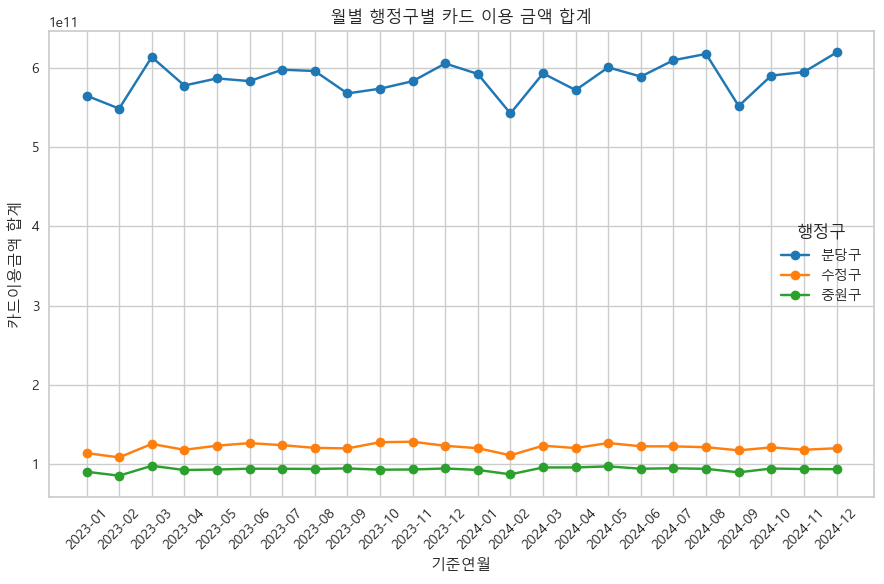

In [ ]:
# card_total=pd.concat([data_2023,data_2024])

# card_total['읍면동'].unique()
# seongnam = {
#     "분당구": [
#         '고등동', '구미1동', '구미동', '금곡동', '백현동', '삼평동', '서현1동', '서현2동', 
#         '수내1동', '수내2동', '수내3동', '야탑1동', '야탑2동', '야탑3동', '운중동', 
#         '이매1동', '이매2동', '정자1동', '정자2동', '정자3동', '정자동', '판교동'
#     ],
#     "중원구": [
#         '금광1동', '금광2동', '단대동', '상대원1동', '상대원2동', '상대원3동', 
#         '성남동', '은행1동', '은행2동', '중앙동', '하대원동'
#     ],
#     "수정구": [
#         '복정동', '산성동', '수진1동', '수진2동', '신촌동', '신흥1동', 
#         '신흥2동', '신흥3동', '양지동', '위례동', '태평1동', '태평2동', 
#         '태평3동', '태평4동'
#     ]
# }

# ages = {
#     "20대": ['20대초', '20대후'],
#     "30대": ['30대초', '30대후'],
#     "40대": ['40대초', '40대후'],
#     "50대": ['50대초', '50대후'],
#     "60대이상": ['60대초', '60대후', '70대이상']
# }

# card_total['기준일자'] = pd.to_datetime(card_total['기준일자'], format='%Y%m%d')
# card_total['기준연월'] = pd.to_datetime(card_total['기준일자']).dt.to_period('M')
# card_total['기준연월'] = card_total['기준연월'].astype(str)

# def get_district(emd):
#     for district, emd_list in seongnam.items():
#         if emd in emd_list:
#             return district
        
# def get_age(emd):
#     for age, emd_list in ages.items():
#         if emd in emd_list:
#             return age
        
# card_total['구'] = card_total['읍면동'].apply(get_district)
# card_total['나이대'] = card_total['연령대별'].apply(get_age)

# temp=card_total.groupby(["기준연월", "구"])["카드이용금액_sum"].sum().reset_index()
# temp

# plt.figure(figsize=(9, 6))

# color_mapping = {
#     "분당구": "#1f77b4",
#     "수정구": "#ff7f0e",
#     "중원구": "#2ca02c"
# }

# for district in temp['구'].unique():
#     subset = temp[temp['구'] == district]
#     plt.plot(subset['기준연월'], subset['카드이용금액_sum'], marker='o', label=district, color=color_mapping[district])

# plt.title('월별 행정구별 카드 이용 금액 합계')
# plt.xlabel('기준연월')
# plt.ylabel('카드이용금액 합계')
# plt.legend(title='행정구')
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

### <그림 6, 월별 행정구별 상품권 결제량 합계>

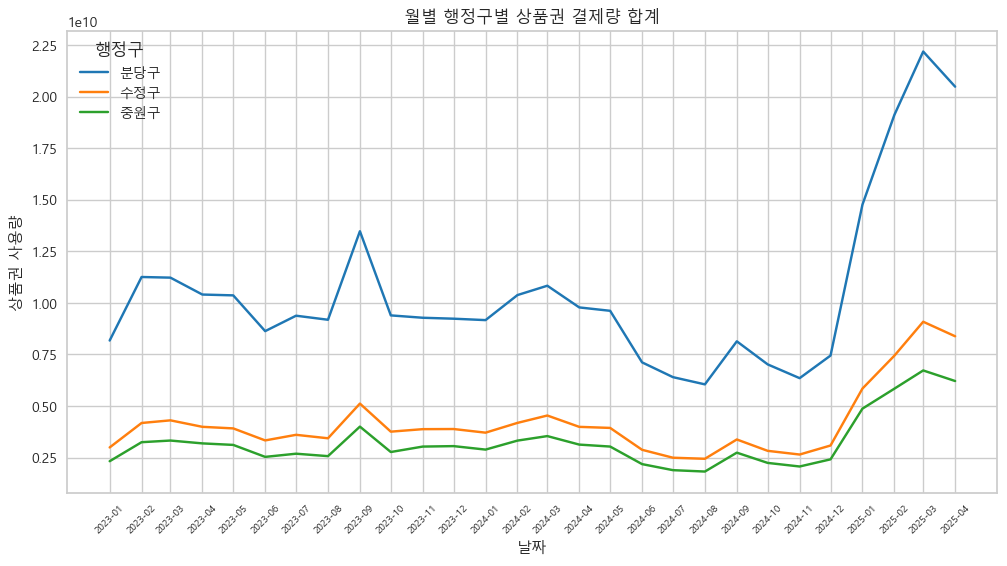

In [18]:
temp=data_gift.groupby(["crtr_ym","usage_rgn_cd","emd_nm"]).agg({"stlm_amt":"sum","stlm_nocs":"sum"}).sort_values(by=["crtr_ym","stlm_amt"], ascending=[True,False]).reset_index()
temp_big=temp.groupby(["crtr_ym","usage_rgn_cd"]).agg({"stlm_amt":"sum","stlm_nocs":"sum"}).sort_values(by=["crtr_ym","stlm_amt"], ascending=[True,False]).reset_index()
temp_2023 = temp_big[temp_big['crtr_ym'] >= '2023-01-01']

plt.figure(figsize=(12, 6))

color_mapping = {
    "분당구": "#1f77b4",
    "수정구": "#ff7f0e",
    "중원구": "#2ca02c"
}
x_order = sorted(temp_2023["crtr_ym"].unique())
x_labels = [d.strftime('%Y-%m') for d in x_order]

for region in temp_2023['usage_rgn_cd'].unique():
    subset = temp_2023[temp_2023['usage_rgn_cd'] == region]
    plt.plot(subset['crtr_ym'], subset['stlm_amt'], label=region, color=color_mapping[region])
plt.xlabel('날짜')
plt.ylabel('상품권 사용량')
plt.title('월별 행정구별 상품권 결제량 합계')
plt.legend(title='행정구')
plt.xticks(ticks=x_labels, labels=x_labels, rotation=45, fontsize=7)
plt.grid(True)

plt.show()

###  <그림 7, 상권 종류별 연령대 평균 매출 비율>

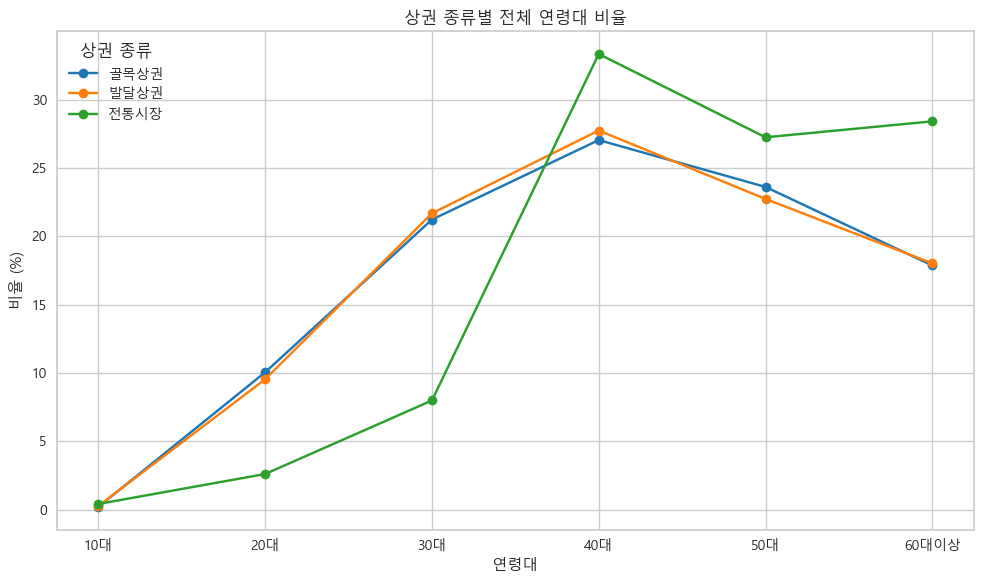

In [ ]:
df=data_big_original.copy()

df["전체-10대비율"]=df[["서비스업-10대비율","소매업-10대비율","음식업-10대비율"]].mean(axis=1)
df["전체-20대비율"]=df[["서비스업-20대비율","소매업-20대비율","음식업-20대비율"]].mean(axis=1)
df["전체-30대비율"]=df[["서비스업-30대비율","소매업-30대비율","음식업-30대비율"]].mean(axis=1)
df["전체-40대비율"]=df[["서비스업-40대비율","소매업-40대비율","음식업-40대비율"]].mean(axis=1)
df["전체-50대비율"]=df[["서비스업-50대비율","소매업-50대비율","음식업-50대비율"]].mean(axis=1)
df["전체-60대이상비율"]=df[["서비스업-60대이상비율","소매업-60대이상비율","음식업-60대이상비율"]].mean(axis=1)

temp=df.groupby("상권종류")[["전체-10대비율","전체-20대비율","전체-30대비율","전체-40대비율","전체-50대비율","전체-60대이상비율"]].mean().reset_index()

plt.figure(figsize=(10, 6))
color_mapping = {
    "골목상권": "#1f77b4",
    "발달상권": "#ff7f0e",
    "전통시장": "#2ca02c"
}
# 상권 종류별로 꺾은선 그래프
for market in temp['상권종류']:
    subset = temp[temp['상권종류'] == market]
    plt.plot(
        ["10대", "20대", "30대", "40대", "50대", "60대이상"], 
        subset.iloc[0, 1:], marker='o', label=market, color=color_mapping[market]
    )

plt.title("상권 종류별 전체 연령대 비율")
plt.xlabel("연령대")
plt.ylabel("비율 (%)")
plt.legend(title="상권 종류")
plt.grid(True)
plt.tight_layout()
plt.show()

#  3. 데이터 전처리

##  3-1) 파생변수 생성

In [19]:
data_big["평일"]=data_big[['월','화', '수', '목','금']].sum(axis=1)
data_big["주말"]=data_big[['토', '일']].sum(axis=1)
data_big["주간"]=data_big[['06~11', '11~13', '13~17']].sum(axis=1)
data_big["저녁"]=data_big[['17~21']].sum(axis=1)
data_big["야간"]=data_big[['21~01', "01~06"]].sum(axis=1)

data_big=data_big[['성남상권', '상권명', '상권종류', '분기', '매출총액', '매출건수', '서비스업', '소매업', '음식업',
                   '서비스업-10대비율','서비스업-20대비율','서비스업-30대비율','서비스업-40대비율', '서비스업-50대비율', '서비스업-60대이상비율', '서비스업-남자비율', '서비스업-여자비율',
                    '소매업-10대비율', '소매업-20대비율', '소매업-30대비율', '소매업-40대비율', '소매업-50대비율','소매업-60대이상비율', '소매업-남자비율', '소매업-여자비율',
                    '음식업-10대비율', '음식업-20대비율','음식업-30대비율', '음식업-40대비율', '음식업-50대비율', '음식업-60대이상비율', '음식업-남자비율','음식업-여자비율',
                    '평일', '주말', '주간', '저녁', '야간']]

## 3-2) 데이터 변환

### <그림 8,“서비스업”,”소매업”,”음식업”히스토그램과 log(1+x) 로그변환 이후의 히스토그램>

In [20]:
temp=data_big.iloc[:,6:9] #데이터 변환과정을 살펴볼 임시 데이터

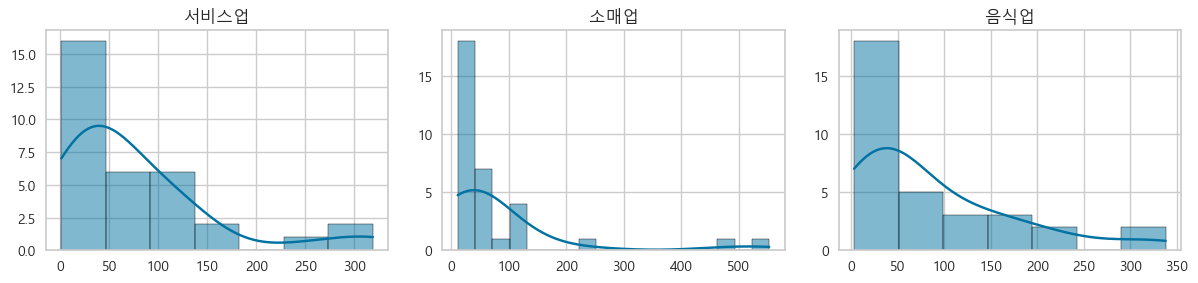

In [21]:
cols = temp.columns
# 한 줄에 5개씩
n_cols = 5
n_rows = math.ceil(len(cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten() 

for i, col in enumerate(cols):
    sns.histplot(temp[col], kde=True, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

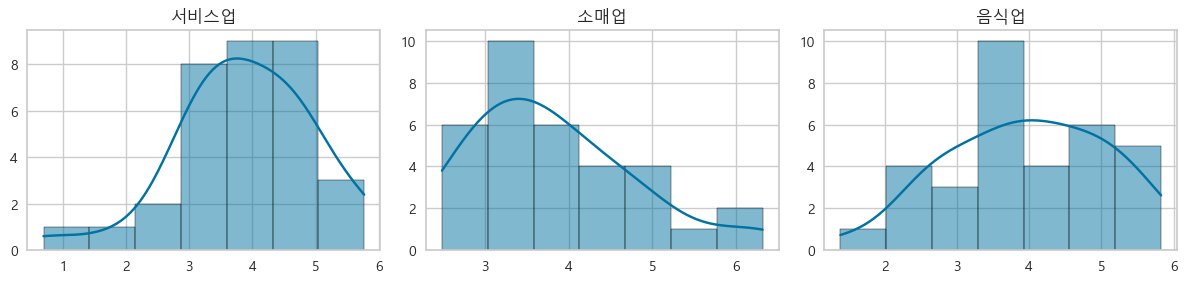

In [22]:
cols = temp.columns
# 한 줄에 5개씩
n_cols = 5
n_rows = math.ceil(len(cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten() 

for i, col in enumerate(cols):
    sns.histplot(np.log1p(temp)[col], kde=True, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 3-3) 요인분석 적합성 테스트

### 1차 KMO 검정

In [23]:
#로그변환
data_big[['서비스업', '소매업', '음식업']] = data_big[['서비스업', '소매업', '음식업']].apply(np.log1p)

#정규화
scaler = StandardScaler()

#적용
scale_data = data_big.drop(columns=["성남상권","상권명","분기","상권종류","매출총액","매출건수"], axis=1).copy()
scale_data.loc[:,:] = scaler.fit_transform(scale_data)

In [24]:
# KMO 검사
kmo_all, kmo_model = calculate_kmo(scale_data)
print(f"KMO: {kmo_model}")

KMO: 0.42292071864685465


C:\Users\swoo6\AppData\Roaming\Python\Python312\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


### 2차 KMO 검정

In [25]:
# 변수별 KMO 확인
kmo_df = pd.DataFrame({
    '변수명': scale_data.columns,
    'KMO': kmo_all
}).sort_values(by='KMO')
# 하위 변수 상위 n개 확인
print(kmo_df.head(10))

             변수명       KMO
11     소매업-10대비율  0.152112
3     서비스업-10대비율  0.221894
22     음식업-40대비율  0.246333
1            소매업  0.257904
6     서비스업-40대비율  0.283972
7     서비스업-50대비율  0.296466
19     음식업-10대비율  0.302232
30            저녁  0.303340
8   서비스업-60대이상비율  0.313131
29            주간  0.330407


업종별 연령대 - “10대비율”변수 제거

In [26]:
temp=data_big.drop(columns=["성남상권","상권명","분기","상권종류","매출총액","매출건수"], axis=1).copy()
temp1=temp[['서비스업-10대비율', '서비스업-20대비율', '서비스업-30대비율', '서비스업-40대비율', '서비스업-50대비율','서비스업-60대이상비율', 
           '소매업-10대비율', '소매업-20대비율', '소매업-30대비율', '소매업-40대비율', '소매업-50대비율', '소매업-60대이상비율', 
           '음식업-10대비율', '음식업-20대비율', '음식업-30대비율', '음식업-40대비율','음식업-50대비율', '음식업-60대이상비율']]
temp2=temp.drop(columns=temp1.columns, axis=1).copy()

cols_service = ['서비스업-20대비율', '서비스업-30대비율', '서비스업-40대비율', '서비스업-50대비율', '서비스업-60대이상비율']
subset_service = temp1[cols_service]
row_sum_service = subset_service.sum(axis=1)
normalized_service = subset_service.div(row_sum_service, axis=0) * 100

cols_somae = ['소매업-20대비율', '소매업-30대비율', '소매업-40대비율', '소매업-50대비율', '소매업-60대이상비율']
subset_somae = temp1[cols_somae]
row_sum_somae = subset_somae.sum(axis=1)
normalized_somae = subset_somae.div(row_sum_somae, axis=0) * 100

cols_food = ['음식업-20대비율', '음식업-30대비율', '음식업-40대비율', '음식업-50대비율', '음식업-60대이상비율']
subset_food = temp1[cols_food]
row_sum_food = subset_food.sum(axis=1)
normalized_food = subset_food.div(row_sum_food, axis=0) * 100

data_big_re=pd.concat([temp2, normalized_service, normalized_somae, normalized_food], axis=1)

#정규화
scaler = StandardScaler()

#적용
scale_data = data_big_re.copy()
scale_data.loc[:,:] = scaler.fit_transform(scale_data)

In [27]:
# KMO 검사
kmo_all, kmo_model = calculate_kmo(scale_data)
print(f"KMO: {kmo_model}")

KMO: 0.47498819934488795


C:\Users\swoo6\AppData\Roaming\Python\Python312\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


##  3-4) 전처리 결과

In [28]:
scale_data.columns

Index(['서비스업', '소매업', '음식업', '서비스업-남자비율', '서비스업-여자비율', '소매업-남자비율', '소매업-여자비율',
       '음식업-남자비율', '음식업-여자비율', '평일', '주말', '주간', '저녁', '야간', '서비스업-20대비율',
       '서비스업-30대비율', '서비스업-40대비율', '서비스업-50대비율', '서비스업-60대이상비율', '소매업-20대비율',
       '소매업-30대비율', '소매업-40대비율', '소매업-50대비율', '소매업-60대이상비율', '음식업-20대비율',
       '음식업-30대비율', '음식업-40대비율', '음식업-50대비율', '음식업-60대이상비율'],
      dtype='object')

In [29]:
len(scale_data.columns)

29

# 4. 탐색적 요인 분석

##  4-1) 요인 개수

In [30]:
#FA모델 생성
fa = FactorAnalyzer(n_factors=scale_data.shape[1], rotation=None)
fa.fit(scale_data)

ev, v = fa.get_eigenvalues() #고유값

###  <그림 9, 각 요인들의 고유값(Eigen Value)과 기준선(빨간 점선)>

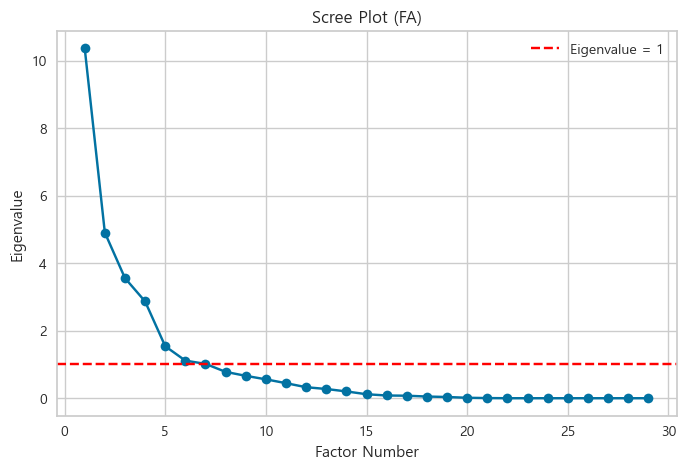

In [31]:
#Scree Plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(ev)+1), ev, marker='o')
plt.axhline(y=1, color='red', linestyle='--', label='Eigenvalue = 1')
plt.title('Scree Plot (FA)')
plt.xlabel('Factor Number')
plt.ylabel('Eigenvalue')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
#고유값 1 이상인 요인 개수 출력
eigenvalues_over_1 = ev[ev >= 1]
print(f"요인 고유값이 1 이상인 개수: {len(eigenvalues_over_1)}개")
print("고유값 1 이상인 목록:")
print(eigenvalues_over_1)

요인 고유값이 1 이상인 개수: 7개
고유값 1 이상인 목록:
[10.36801717  4.90646279  3.55794787  2.86765924  1.54012034  1.11374925
  1.01772306]


###  <그림 10, 각 요인들의 분산비율(파랑)과 누적 설명 분산(초록)>

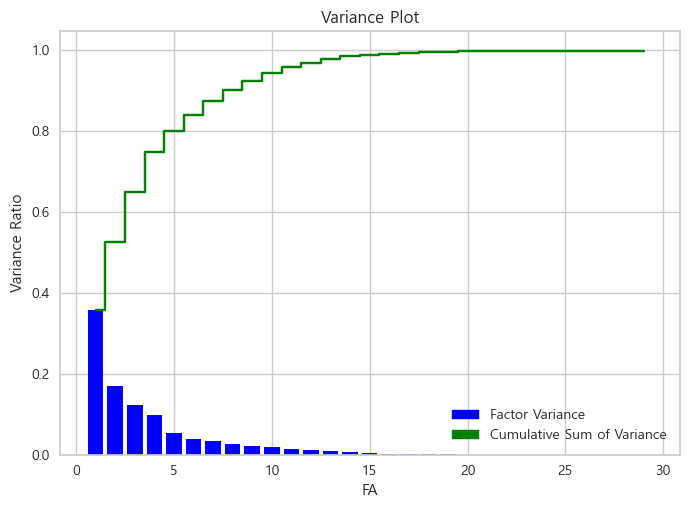

In [33]:
# Scree plot
x_axis = range(1, len(ev)+1)
plt.bar(x_axis, fa.get_factor_variance()[1], align='center', color="blue")
plt.step(x_axis, np.cumsum(fa.get_factor_variance()[1]), where = 'mid', color='green')
plt.xlabel('FA')
plt.ylabel('Variance Ratio')
plt.title('Variance Plot')
blue_patch = mpatches.Patch(color='blue', label='Factor Variance')
green_line = mpatches.Patch(color='green', label='Cumulative Sum of Variance')
plt.legend(handles=[blue_patch, green_line], loc='best')
plt.show()

In [34]:
# 누적 설명 분산 출력
total_variance = np.cumsum(fa.get_factor_variance()[1])
print("누적 설명 분산:", total_variance)

누적 설명 분산: [0.35734542 0.52636138 0.64887682 0.74758921 0.80052439 0.83875713
 0.87367861 0.90043036 0.92313131 0.94225425 0.95746141 0.9685379
 0.97779702 0.98456948 0.98847252 0.99108251 0.99347515 0.99503111
 0.99610892 0.99640036 0.99640036 0.99640036 0.99640036 0.99640036
 0.99640036 0.99640036 0.99640036 0.99640036 0.99640036]


## 4-2) 요인 회전

In [35]:
#요인 개수
fa_num=5

In [36]:
fa = FactorAnalyzer(n_factors=fa_num, rotation='promax')
fa.fit(scale_data)

FactorAnalyzer(n_factors=5, rotation_kwargs={})

###  <그림 11, ‘promax’회전 시 요인상관행렬 히트맵>

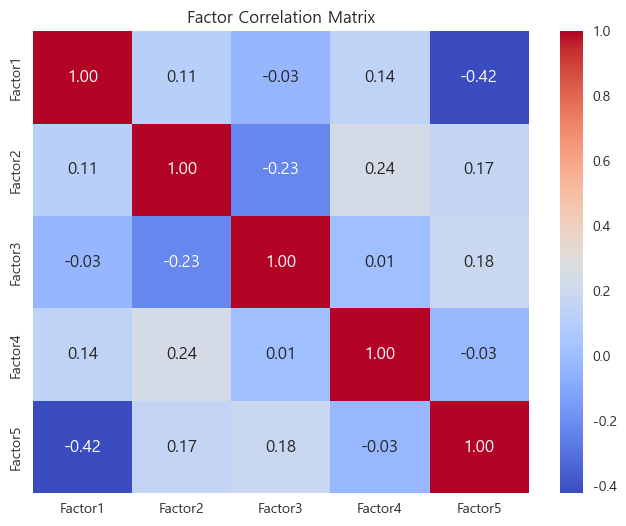

In [37]:
# 요인 상관 행렬 히트맵
plt.figure(figsize=(8, 6))
sns.heatmap(fa.phi_, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, xticklabels=[f"Factor{i+1}" for i in range(fa.phi_.shape[0])], yticklabels=[f"Factor{i+1}" for i in range(fa.phi_.shape[0])])
plt.title("Factor Correlation Matrix")
plt.show()

## 4-3) 공통요인 해석

In [38]:
fa = FactorAnalyzer(n_factors=fa_num, rotation='varimax')
fa.fit(scale_data)

FactorAnalyzer(n_factors=5, rotation='varimax', rotation_kwargs={})

In [39]:
#요인 로딩(factor loadings)
loadings = fa.loadings_

loadings_df = pd.DataFrame(loadings, 
                           index=scale_data.columns, 
                           columns=[f"Factor{i+1}" for i in range(loadings.shape[1])])

In [40]:
threshold = 0.50 # 교차 허용 주성분 점수 임계값
load_abs  = loadings_df.abs() # 주성분 점수의 절댓값

# 임계값 이상인 것만 추출
mask = load_abs >= threshold 

#그룹핑
multi_groups_fa = {
    fa_f: mask.index[mask[fa_f]].tolist()
    for fa_f in loadings_df.columns
}

### <표 2, 각 요인에 할당된 변수의 요인적재량>

In [41]:
for i in range(1, len(multi_groups_fa)+1):
    print(loadings_df.loc[multi_groups_fa[f"Factor{i}"], [f"Factor{i}"]].sort_values(by=f"Factor{i}", ascending=False), "\n")

              Factor1
음식업-50대비율    0.819884
서비스업-여자비율    0.763983
소매업-60대이상비율  0.689706
서비스업-50대비율   0.645562
음식업-60대이상비율  0.634749
소매업-여자비율     0.512138
소매업-남자비율    -0.512138
소매업-30대비율   -0.554987
서비스업-20대비율  -0.641955
소매업-40대비율   -0.654796
서비스업-남자비율   -0.763983
음식업-30대비율   -0.868381
서비스업-30대비율  -0.874730 

              Factor2
음식업-남자비율     0.913121
소매업-남자비율     0.723356
소매업-30대비율    0.712144
음식업-20대비율    0.692403
소매업-20대비율    0.654718
야간           0.557040
음식업          0.515195
음식업-60대이상비율 -0.503937
주간          -0.504068
소매업-60대이상비율 -0.508515
소매업-50대비율   -0.536392
소매업-여자비율    -0.723356
음식업-여자비율    -0.913121 

     Factor3
주말  0.944873
저녁  0.780069
주간 -0.658257
평일 -0.944960 

               Factor4
서비스업-60대이상비율  0.640620
소매업-40대비율    -0.511862
서비스업-40대비율   -0.833500
음식업-40대비율    -0.840551 

       Factor5
소매업   0.846139
서비스업  0.715206
음식업   0.690260 



### <표 3, 각 공통요인별 해석>

| Fa | 부호 | 설명 |
| - | - | - |
| Fa1 | + |  여러 업종에서 고령자(5•60대), 소매업에서 여성의 소비가 두드러짐 → 중장년층·여성 소비 중심의 상권 (생필품 시장) | 
| Fa1 | - | 여러 업종에서 30대, 남성 중심 소비가 두드러짐 → 남성 직장인 중심 상권 |
| Fa2 | + | 음식업·소매업에서 20대·남성 소비 비율이 높고, 야간 활동도 크며, 음식업 점포수가 많다 → 심야·젊은 남성 중심 소비 지역 (직장인 회식, 음식가 상권) |
| Fa2 | - | 50·60대, 여성 비중이 높고, 주간 활동이 연관됨 → 중장년·여성 중심의 낮 시간대 상권 |
| Fa3 | + | 주말·저녁 시간 활동이 매우 강함→ 주말·저녁 중심 상권 |
| Fa3 | - | 주중·주간 활동이 많음→ 평일 중심 오피스·런치 상권 |
| Fa4 | + | 서비스업에서 60대 이상 비중이 높음→ 고령층 대상 의원 상권 |
| Fa4 | - | 40대 비율이 높은 음식·서비스·소매업→ 중년층 중심 상권 |
| Fa5 | + | 업종 규모 요인 (소매·음식·서비스업 점포수 모두 높음)→ 대규모 복합 상업지역 |

In [42]:
#Regression 점수 차원축소 데이터
factor_scores_df = pd.DataFrame(
    fa.transform(scale_data),
    columns=[f"FA{i+1}" for i in range(fa.n_factors)],
    index=scale_data.index
)

#  5. 군집 분석

In [43]:
#데이터 선택
data=factor_scores_df #FA 차원축소

## 5-1) 군집 개수 설정

### ① Elbow method

###  <그림 12, Elbow Method - Scree Plot> 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

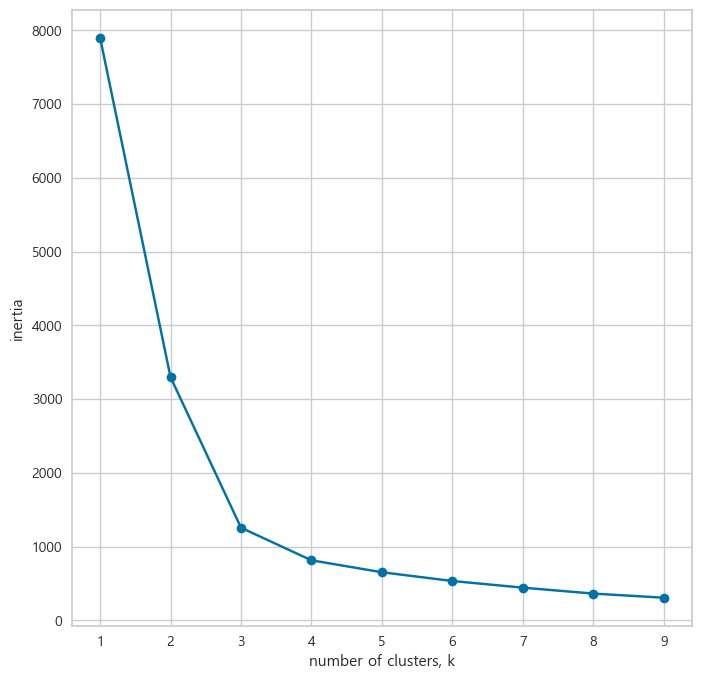

In [ ]:
ks = range(1,10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k, random_state=42, n_init=10, init="k-means++")
    model.fit(data)
    inertias.append(model.inertia_)

plt.figure(figsize=(8, 8))
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

### ② 실루엣 점수

###  <그림 13, 각 클러스터 개수별 실루엣 점수와 실루엣 점수 시각화>

In [45]:
k_range = range(2, 10)
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init="k-means++")
    cluster_labels = kmeans.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels) #실루엣 계수 계산
    silhouette_scores.append({
        'k': k,
        'silhouette_score': silhouette_avg
    })

silhouette_df = pd.DataFrame(silhouette_scores)
silhouette_df

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

,k,silhouette_score
0,2,0.545162
1,3,0.555368
2,4,0.472489
3,5,0.431046
4,6,0.423127
5,7,0.355667
6,8,0.325926
7,9,0.329159


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

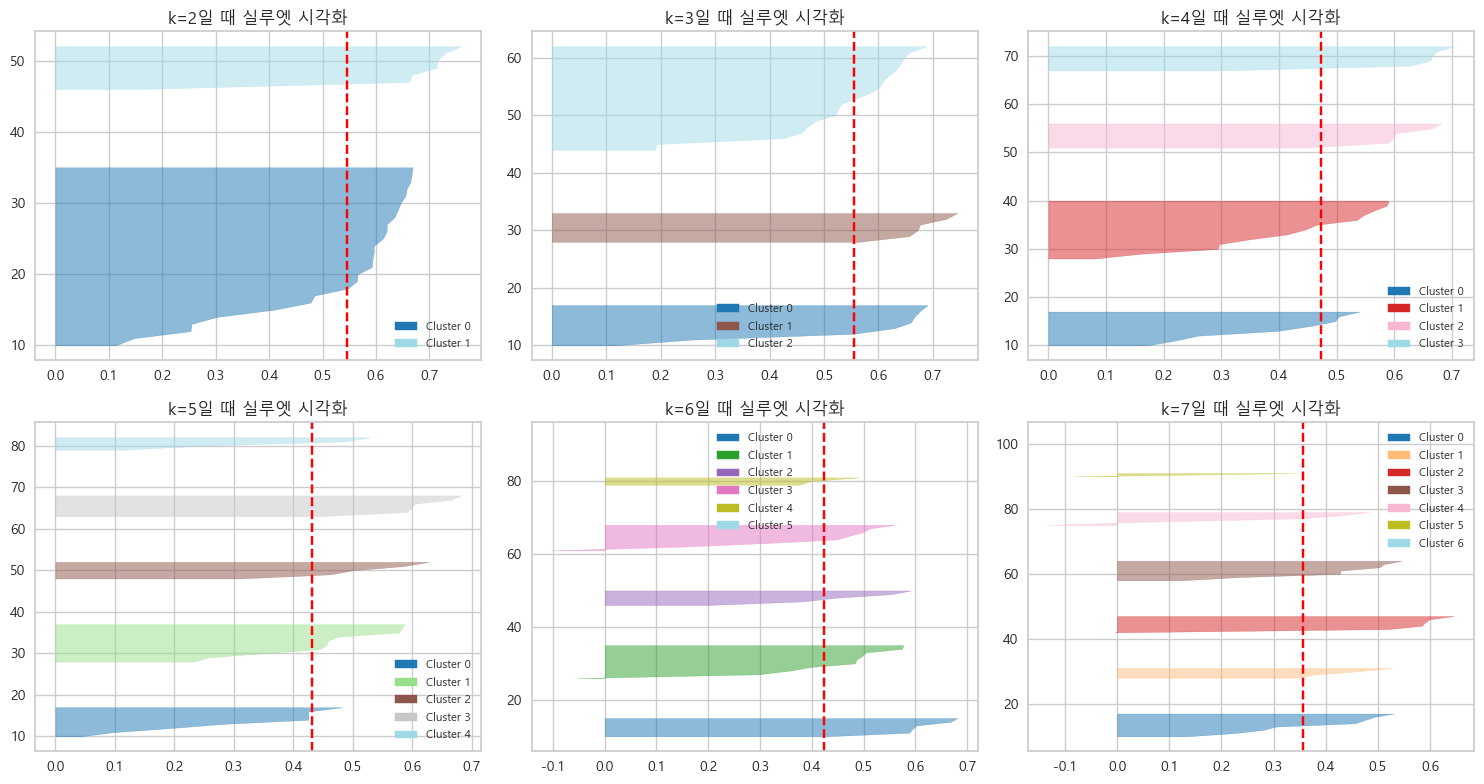

In [46]:
#몇개의 클러스터링까지 볼것인가
sil_k=7
rows = math.ceil((sil_k - 1) / 3)
fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 4))
axes = axes.flatten()

for idx, k in enumerate(range(2, sil_k + 1)):
    #클러스터링
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init="k-means++")

    #색상 설정
    cmap = colormaps['tab20']
    colors = [cmap(i / (k - 1)) for i in range(k)]

    #실루엣 시각화
    viz = SilhouetteVisualizer(kmeans, ax=axes[idx], colors=colors)
    viz.fit(data)
    axes[idx].set_title(f'k={k}일 때 실루엣 시각화')

    #legend
    handles = [
        mpatches.Patch(color=colors[i], label=f"Cluster {i}")
        for i in range(k)
    ]
    axes[idx].legend(handles=handles, loc="best", fontsize=8, frameon=False)
    
# 남은 subplot 삭제
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

## 5-2) 군집분석 결과 및 시각화

In [47]:
#클러스터링 개수 지정
cluster=4

In [48]:
kmeans = KMeans(n_clusters=cluster, random_state=42, n_init=10, init="k-means++")
data_km=data.copy()
data_km['cluster'] = kmeans.fit_predict(data)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### <그림 14, 각 군집별 할당된 데이터의 개수> 

In [69]:
pd.DataFrame(data_km['cluster'].value_counts().sort_index())


,count
cluster,
0,8
1,13
2,6
3,6


###  <그림 15, 각 군집별 공통 요인 차원축소 데이터 히스토그램>

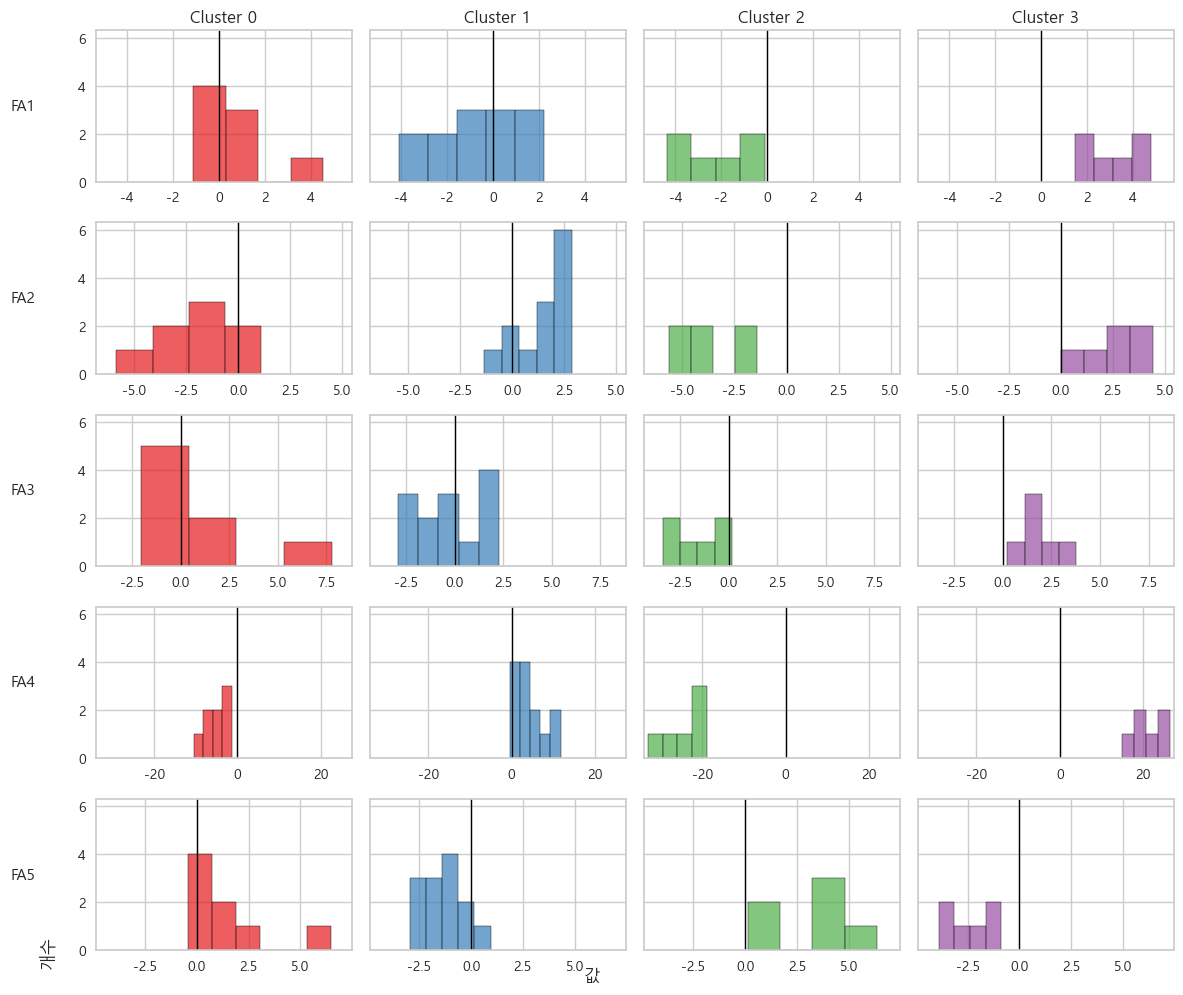

In [ ]:
# 변수 및 클러스터 목록
variables  = [c for c in data_km.columns if c != 'cluster']
clusters   = sorted(data_km['cluster'].unique())
n_vars     = len(variables)
n_clusters = len(clusters)

# 색상 맵
colors = sns.color_palette("Set1", n_clusters)

# y축만 공유
fig, axes = plt.subplots(
    n_vars, n_clusters,
    figsize=(n_clusters * 3, n_vars * 2),
    sharex=False, sharey=True
)


for i, var in enumerate(variables):
    # 변수 전체 범위 고정용
    vmin, vmax = data_km[var].min()-1, data_km[var].max()+1
    
    for j, cl in enumerate(clusters):
        ax = axes[i, j]
        subset = data_km[data_km['cluster'] == cl]
        
        sns.histplot(
            data=subset,
            x=var,
            # stat="density",        # 밀도로 표시
            # common_norm=False,     # 각 클러스터별 개수로 정규화
            # bins=10,
            common_bins=True, #모든 플롯의 bin을 동일하게 설정
            ax=ax,
            fill=True,
            alpha=0.7,
            color=colors[j]
        )
        
        # 같은 변수의 서브플롯끼리 동일 x축 범위
        ax.set_xlim(vmin, vmax)
        # ax.set_ylim(0, 400)
        # 개별 서브플롯의 x축 레이블 제거
        ax.set_xlabel('')
        # x=0에 검은색 수직선 추가
        ax.axvline(0, color='black', linewidth=1)

        if i == 0:
            ax.set_title(f'Cluster {cl}')
        if j == 0:
            ax.set_ylabel(var, rotation=0, labelpad=40, va='center')

# 전체 레이블 및 레이아웃
fig.tight_layout()
fig.text(0.5, 0.01, '값', ha='center')
fig.text(0.04, 0.04, '개수', va='center', rotation='vertical')
plt.show()

In [54]:
store_clust=pd.concat([data_big[data_big.columns[:3]],round(data_km.drop(columns=["cluster"], axis=1), 2),data_km["cluster"]], axis=1)
store_clust.head()

,성남상권,상권명,상권종류,FA1,FA2,FA3,FA4,FA5,cluster
0,야탑 먹자골목,야탑1동주민센터,발달상권,-1.23,-3.65,-1.37,-22.80,4.32,2
1,야탑역 상권,야탑역,발달상권,1.47,3.15,0.23,20.35,-2.21,3
2,야탑3동 상권,매화로,발달상권,-1.13,-1.25,-2.06,-6.49,0.28,0
3,판교테크노벨리,판교역로,발달상권,-0.91,2.18,-2.93,1.72,-1.08,1
4,판교테크노벨리,아이큐아리움,발달상권,-1.31,2.63,-2.91,3.23,-0.85,1


### 5-3) 공간 시각화

In [53]:
map_clust=pd.concat([data_big[data_big.columns[0:3]],data_km.iloc[:,-1]], axis=1)
map_clust=map_clust.merge(location, on=["성남상권","상권명","상권종류"],how="inner")

### <그림 16, 각 군집별 지역 상권 시각화>

In [ ]:
# 클러스터별 색상
cluster_colors = {
    0: 'red',
    1: 'blue',    
    2: 'green',   
    3: 'purple',  
}

# 지도 중심 설정
center_lat = map_clust['latitude'].mean()
center_lon = map_clust['longitude'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=14)

# 팝업 추가
for idx, row in map_clust.iterrows():
    cluster_id = row['cluster']
    color = cluster_colors.get(cluster_id, 'gray')
    
    html = f"""
    <b>상권명:</b> {row['상권명']}<br>
    <b>성남상권:</b> {row['성남상권']}<br>
    <b>상권종류:</b> {row['상권종류']}<br>
    <b>Cluster:</b> {row['cluster']}
    """
    
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(html, max_width=250),
        icon=folium.Icon(color=color)
    ).add_to(m)

m #지도 출력


# 6. 시범 상권 선정

In [56]:
store_clust[(store_clust["cluster"]==3)&(store_clust["상권종류"]=="전통시장")].sort_values(by="cluster")

,성남상권,상권명,상권종류,FA1,FA2,FA3,FA4,FA5,cluster
24,수내 전통상권,금호시장,전통시장,4.61,0.00,2.30,21.46,-1.09,3
30,서현 전통상권,분당우성시장,전통시장,3.51,2.54,1.28,25.28,-3.34,3
32,서현 전통상권,미래타운제2종합시장,전통시장,2.53,1.86,1.23,14.94,-3.90,3


In [57]:
store_clust[(store_clust["cluster"]==0)&(store_clust["FA1"]>0)&(store_clust["FA2"]<0)&(store_clust["상권종류"]=="전통시장")]

,성남상권,상권명,상권종류,FA1,FA2,FA3,FA4,FA5,cluster
26,수내 전통상권,돌고래시장,전통시장,0.92,-3.49,-0.86,-4.61,1.06,0


아래는 분당구의 전통시장 중 총점포수 합계 순위를 매긴 것이다

In [ ]:
df_q = (
    data_big_original
    .query("분기 == '2024년2분기'")
    .loc[:, ["성남상권", "상권명", "상권종류", "서비스업", "소매업", "음식업"]]
    .assign(합계=lambda d: d[["서비스업", "소매업", "음식업"]].sum(axis=1))
)

df_q = df_q.assign(
    순위 = lambda d: d
        .groupby("상권종류")
        ["합계"]   
        .rank(method="dense", ascending=False) 
        .astype(int)
)

df_q[df_q["상권명"].isin(["금호시장","분당우성시장","미래타운제2종합시장","돌고래시장"])]

,성남상권,상권명,상권종류,서비스업,소매업,음식업,합계,순위
24,수내 전통상권,금호시장,전통시장,50.0,124.0,46.0,220.0,1
26,수내 전통상권,돌고래시장,전통시장,13.0,71.0,28.0,112.0,4
30,서현 전통상권,분당우성시장,전통시장,29.0,19.0,14.0,62.0,7
32,서현 전통상권,미래타운제2종합시장,전통시장,15.0,11.0,13.0,39.0,8


아래는 분당구의 전통시장 중 매출총액과 매출건수의 순위를 매긴 것이다

In [59]:
df_p=data_big_original.query("분기=='2024년2분기'")[["상권명","상권종류","매출총액","매출건수"]].copy()
df_p = df_p.assign(
    매출총액순위=lambda d: d.groupby("상권종류")["매출총액"].rank(method="dense", ascending=False).astype(int),
    매출건수순위=lambda d: d.groupby("상권종류")["매출건수"].rank(method="dense", ascending=False).astype(int)
)

df_p[df_p["상권명"].isin(["금호시장", "분당우성시장","미래타운제2종합시장","돌고래시장"])].sort_values(by=["매출총액순위"])

,상권명,상권종류,매출총액,매출건수,매출총액순위,매출건수순위
30,분당우성시장,전통시장,86339079.0,3313.0,1,1
32,미래타운제2종합시장,전통시장,33180640.0,1200.0,3,4
26,돌고래시장,전통시장,27006428.0,1262.0,6,3
24,금호시장,전통시장,16728277.0,507.0,9,9


## 6-1) 금호시장 (수내 전통상권 – 군집3)

### <그림 17, 금호시장 상권 특성>

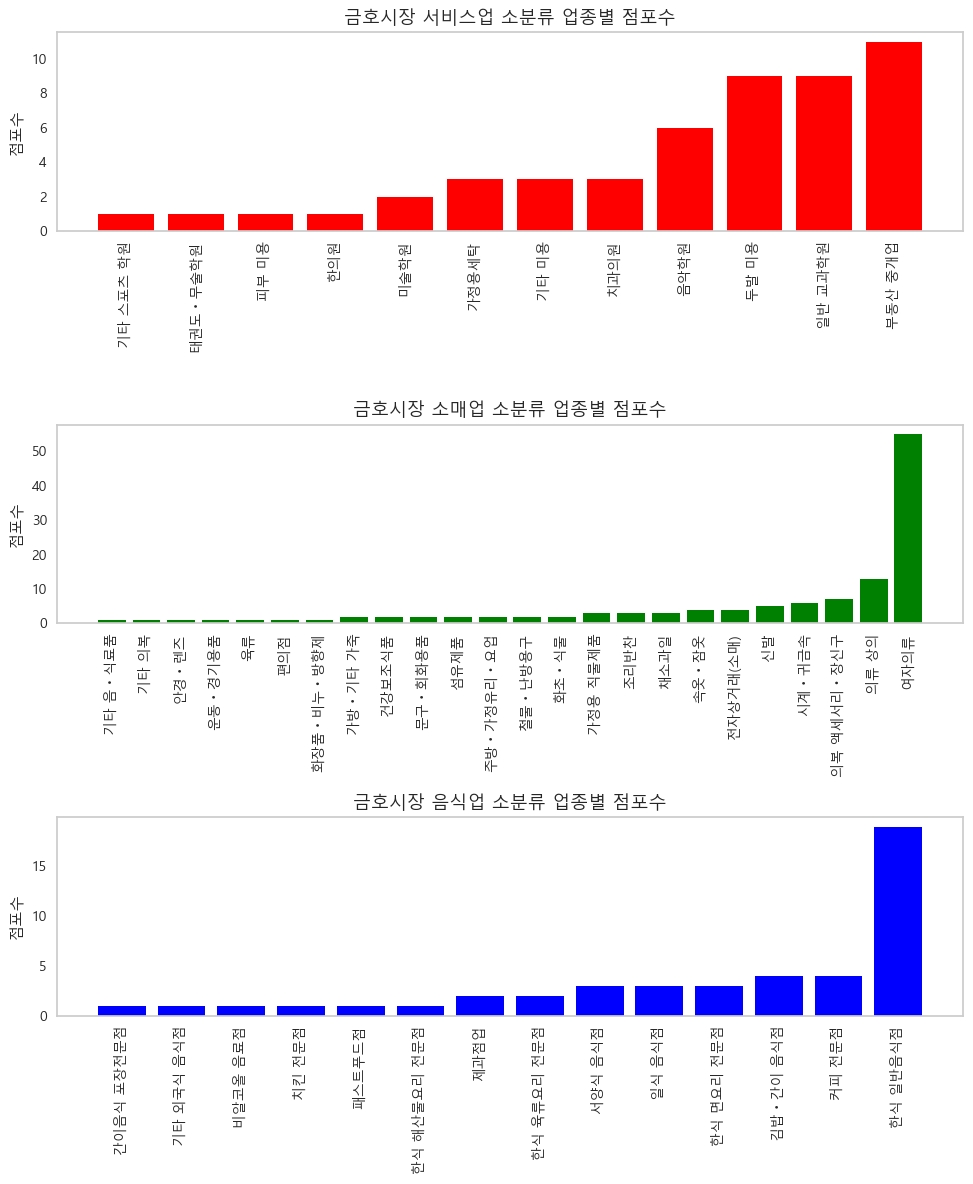

In [60]:
sn_commercial="수내 전통상권" #성남상권
commercial_name='금호시장' #상권명
commercial_type="전통시장" #상권종류 (발달상권, 골목상권, 전통시장)
quarter="2024년2분기"

df=data_small.query("성남상권==@sn_commercial & 상권명==@commercial_name & 상권종류==@commercial_type & 분기==@quarter").copy()
df=df.drop(columns=["성남상권","상권종류","분기","매출총액","매출건수"])
df=df.sort_values(by=["업종대분류","점포수"])

# 색상 매핑 딕셔너리
color_map = {
    "서비스업": "red",
    "소매업": "green",
    "음식업": "blue"
}

store_type = ["서비스업", "소매업", "음식업"]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=False)

for i, type_big in enumerate(store_type):
    temp = df[(df["업종대분류"] == type_big) & (df["점포수"] > 0)]
    axes[i].bar(temp["업종"], temp["점포수"], color=color_map[type_big])
    axes[i].set_title(f"{commercial_name} {type_big} 소분류 업종별 점포수", fontsize=13)
    axes[i].set_ylabel("점포수")
    axes[i].tick_params(axis='x', labelrotation=90)
    axes[i].grid()
plt.tight_layout()
plt.show()

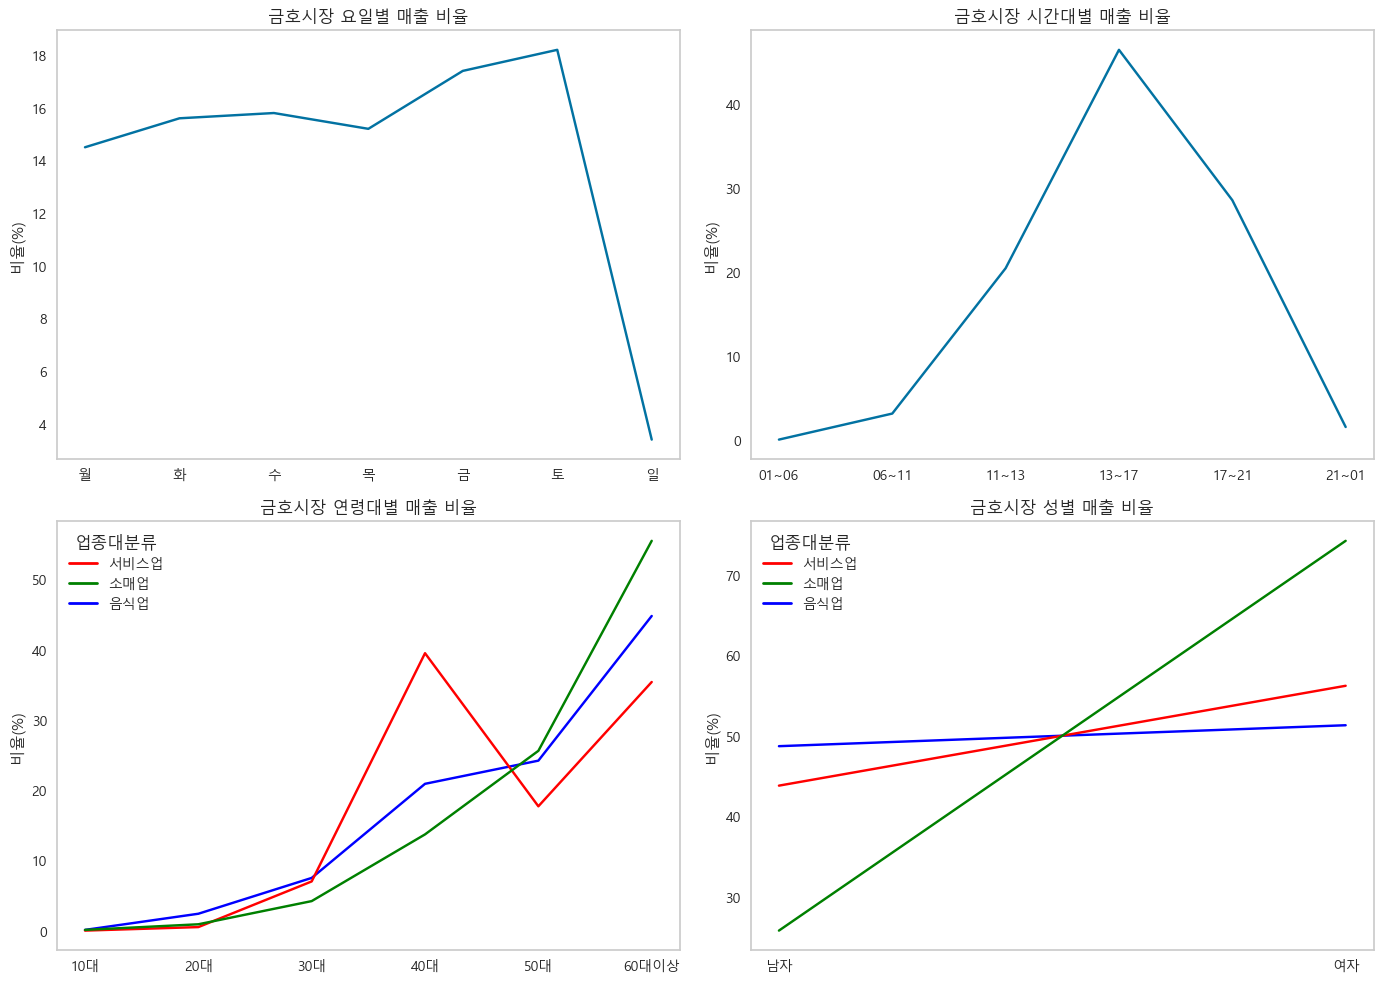

In [61]:
sn_commercial="수내 전통상권" #성남상권
commercial_name='금호시장' #상권명
commercial_type1="전통" #상권종류 (발달, 골목, 전통)
df_day=data_day.query("성남상권==@sn_commercial & 상권==@commercial_name & 종류==@commercial_type1").copy()
df_time=data_time.query("성남상권==@sn_commercial & 상권==@commercial_name & 종류==@commercial_type1").copy()
df_age_sex=data_age_sex.query("성남상권==@sn_commercial & 상권==@commercial_name & 종류==@commercial_type1").copy()

# 업종 색상 정의
industry_colors = {
    '서비스업': 'red',
    '소매업': 'green',
    '음식업': 'blue'
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2행 2열

# 평면화하여 index로 접근
axes = axes.flatten()

# df_day 요일별 선 그래프
df_day.loc[:, ['월', '화', '수', '목', '금', '토', '일']].T.plot(
    ax=axes[0], legend=False, title=f'{commercial_name} 요일별 매출 비율')
axes[0].set_ylabel('비율(%)')
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(['월', '화', '수', '목', '금', '토', '일'])
axes[0].grid()

# df_time 시간대별 선 그래프
df_time.loc[:, ['01~06', '06~11', '11~13', '13~17', '17~21', '21~01']].T.plot(
    ax=axes[1], legend=False, title=f'{commercial_name} 시간대별 매출 비율')
axes[1].set_ylabel('비율(%)')
axes[1].set_xticks(range(6))
axes[1].set_xticklabels(['01~06', '06~11', '11~13', '13~17', '17~21', '21~01'])
axes[1].grid()

# df_age_sex 연령별 선 그래프
for _, row in df_age_sex.iterrows():
    x = ['10대', '20대', '30대', '40대', '50대', '60대이상']
    y = row[x]
    color = industry_colors.get(row['업종'], 'black')
    axes[2].plot(x, y, color=color, label=row['업종'])

axes[2].set_title(f'{commercial_name} 연령대별 매출 비율')
axes[2].set_ylabel('비율(%)')
axes[2].grid()
axes[2].legend(
    handles=[plt.Line2D([0], [0], color=val, lw=2) for val in industry_colors.values()],
    labels=industry_colors.keys(),
    title="업종대분류",
    loc='upper left'
)

# df_age_sex 성별 선 그래프
for _, row in df_age_sex.iterrows():
    x = ['남자', '여자']
    y = row[x]
    color = industry_colors.get(row['업종'], 'black')
    axes[3].plot(x, y, color=color)

axes[3].set_title(f'{commercial_name} 성별 매출 비율')
axes[3].set_ylabel('비율(%)')
axes[3].grid()
axes[3].legend(
    handles=[plt.Line2D([0], [0], color=val, lw=2) for val in industry_colors.values()],
    labels=industry_colors.keys(),
    title="업종대분류",
    loc='upper left'
)

plt.tight_layout()
plt.show()


## 6-2) 돌고래시장 (수내 전통상권 – 군집0)

### <그림 18, 돌고래시장 상권 특성>

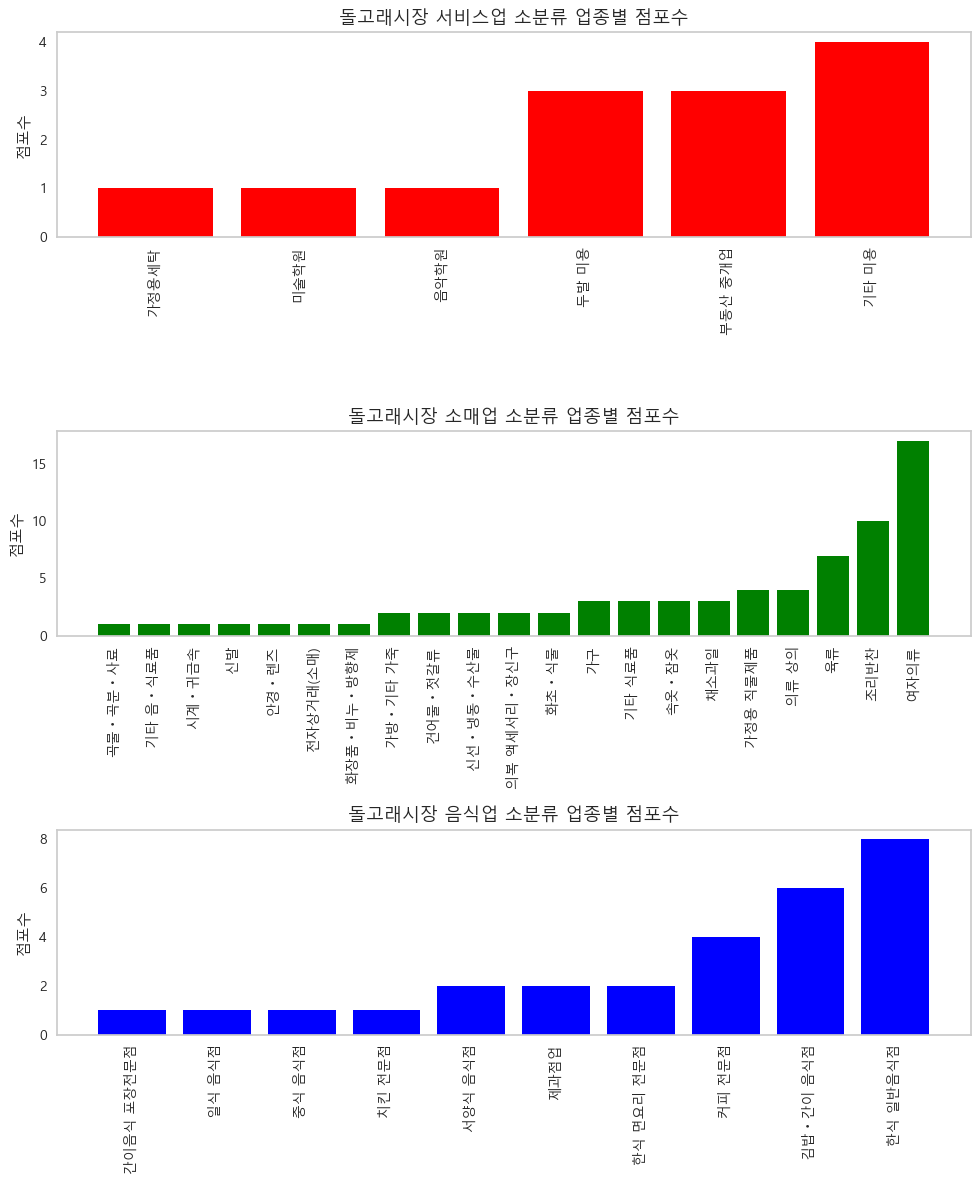

In [62]:
sn_commercial="수내 전통상권" #성남상권
commercial_name='돌고래시장' #상권명
commercial_type="전통시장" #상권종류 (발달상권, 골목상권, 전통시장)
quarter="2024년2분기"

df=data_small.query("성남상권==@sn_commercial & 상권명==@commercial_name & 상권종류==@commercial_type & 분기==@quarter").copy()
df=df.drop(columns=["성남상권","상권종류","분기","매출총액","매출건수"])
df=df.sort_values(by=["업종대분류","점포수"])

# 색상 매핑 딕셔너리
color_map = {
    "서비스업": "red",
    "소매업": "green",
    "음식업": "blue"
}

store_type = ["서비스업", "소매업", "음식업"]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=False)

for i, type_big in enumerate(store_type):
    temp = df[(df["업종대분류"] == type_big) & (df["점포수"] > 0)]
    axes[i].bar(temp["업종"], temp["점포수"], color=color_map[type_big])
    axes[i].set_title(f"{commercial_name} {type_big} 소분류 업종별 점포수", fontsize=13)
    axes[i].set_ylabel("점포수")
    axes[i].tick_params(axis='x', labelrotation=90)
    axes[i].grid()
plt.tight_layout()
plt.show()

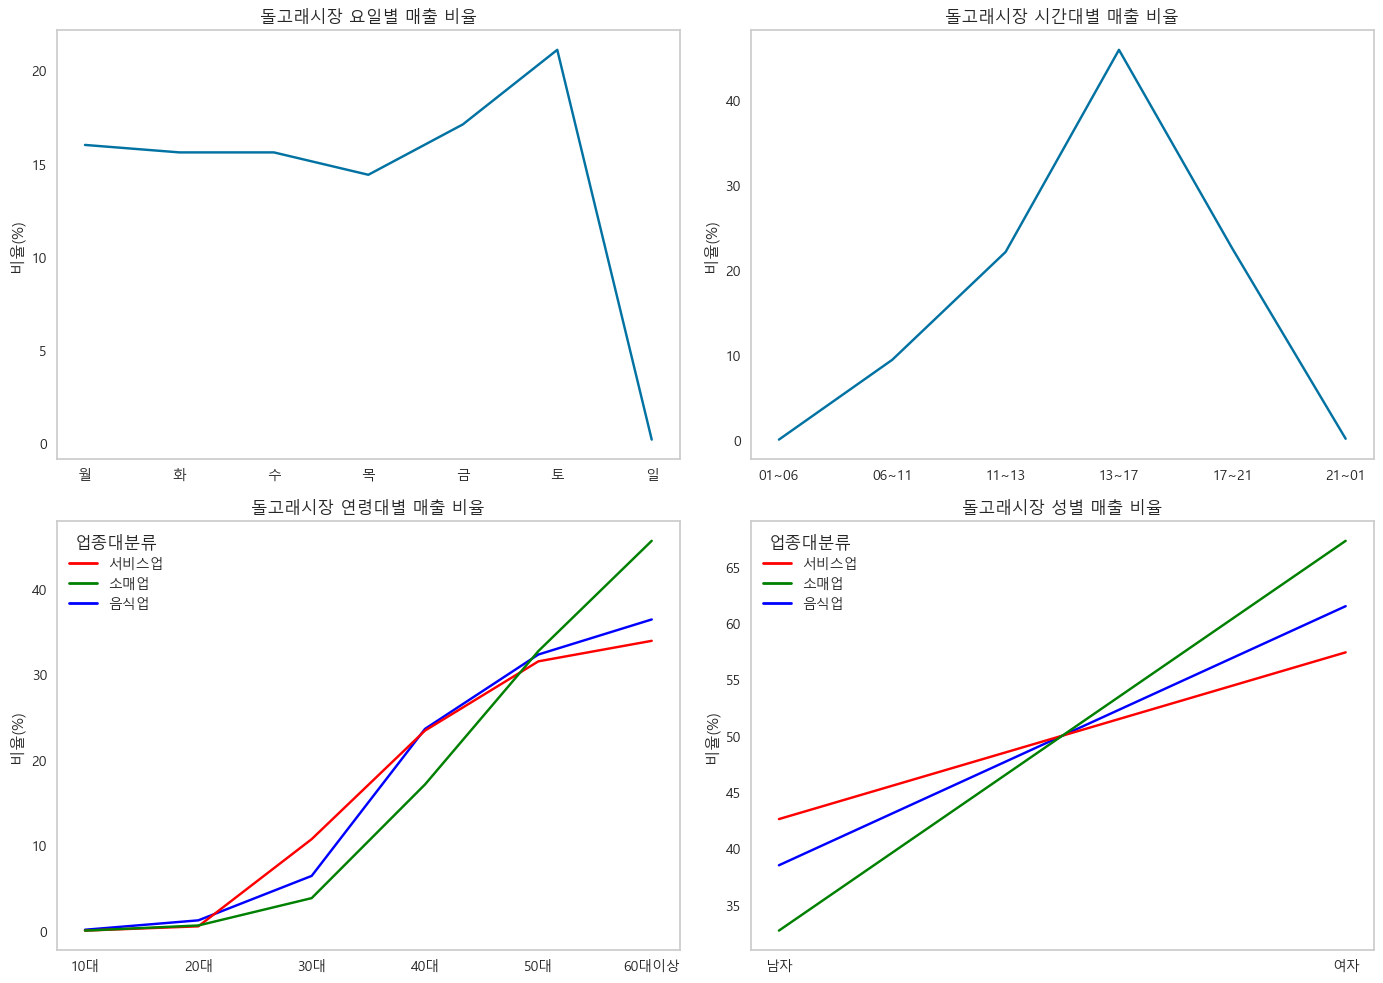

In [63]:
sn_commercial="수내 전통상권" #성남상권
commercial_name='돌고래시장' #상권명
commercial_type1="전통" #상권종류 (발달, 골목, 전통)
df_day=data_day.query("성남상권==@sn_commercial & 상권==@commercial_name & 종류==@commercial_type1").copy()
df_time=data_time.query("성남상권==@sn_commercial & 상권==@commercial_name & 종류==@commercial_type1").copy()
df_age_sex=data_age_sex.query("성남상권==@sn_commercial & 상권==@commercial_name & 종류==@commercial_type1").copy()

# 업종 색상 정의
industry_colors = {
    '서비스업': 'red',
    '소매업': 'green',
    '음식업': 'blue'
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2행 2열

# 평면화하여 index로 접근
axes = axes.flatten()

# df_day 요일별 선 그래프
df_day.loc[:, ['월', '화', '수', '목', '금', '토', '일']].T.plot(
    ax=axes[0], legend=False, title=f'{commercial_name} 요일별 매출 비율')
axes[0].set_ylabel('비율(%)')
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(['월', '화', '수', '목', '금', '토', '일'])
axes[0].grid()

# df_time 시간대별 선 그래프
df_time.loc[:, ['01~06', '06~11', '11~13', '13~17', '17~21', '21~01']].T.plot(
    ax=axes[1], legend=False, title=f'{commercial_name} 시간대별 매출 비율')
axes[1].set_ylabel('비율(%)')
axes[1].set_xticks(range(6))
axes[1].set_xticklabels(['01~06', '06~11', '11~13', '13~17', '17~21', '21~01'])
axes[1].grid()

# df_age_sex 연령별 선 그래프
for _, row in df_age_sex.iterrows():
    x = ['10대', '20대', '30대', '40대', '50대', '60대이상']
    y = row[x]
    color = industry_colors.get(row['업종'], 'black')
    axes[2].plot(x, y, color=color, label=row['업종'])

axes[2].set_title(f'{commercial_name} 연령대별 매출 비율')
axes[2].set_ylabel('비율(%)')
axes[2].grid()
axes[2].legend(
    handles=[plt.Line2D([0], [0], color=val, lw=2) for val in industry_colors.values()],
    labels=industry_colors.keys(),
    title="업종대분류",
    loc='upper left'
)

# df_age_sex 성별 선 그래프
for _, row in df_age_sex.iterrows():
    x = ['남자', '여자']
    y = row[x]
    color = industry_colors.get(row['업종'], 'black')
    axes[3].plot(x, y, color=color)

axes[3].set_title(f'{commercial_name} 성별 매출 비율')
axes[3].set_ylabel('비율(%)')
axes[3].grid()
axes[3].legend(
    handles=[plt.Line2D([0], [0], color=val, lw=2) for val in industry_colors.values()],
    labels=industry_colors.keys(),
    title="업종대분류",
    loc='upper left'
)

plt.tight_layout()
plt.show()


##  6-3) 분당우성시장 (서현 전통상권 – 군집3)

### <그림 19, 분당우성시장 상권 특성>

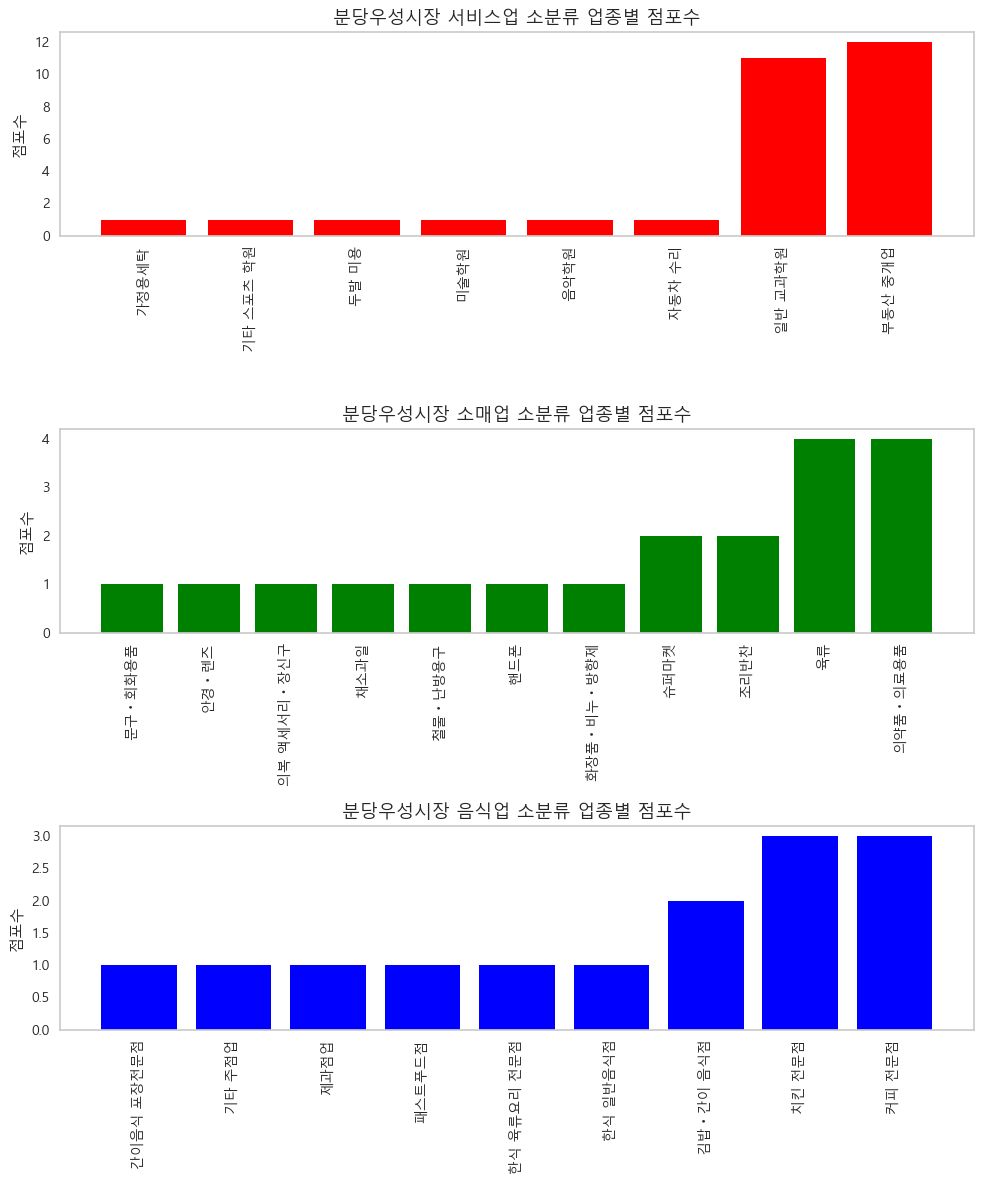

In [64]:
sn_commercial="서현 전통상권" #성남상권
commercial_name='분당우성시장' #상권명
commercial_type="전통시장" #상권종류 (발달상권, 골목상권, 전통시장)
quarter="2024년2분기"

df=data_small.query("성남상권==@sn_commercial & 상권명==@commercial_name & 상권종류==@commercial_type & 분기==@quarter").copy()
df=df.drop(columns=["성남상권","상권종류","분기","매출총액","매출건수"])
df=df.sort_values(by=["업종대분류","점포수"])

# 색상 매핑 딕셔너리
color_map = {
    "서비스업": "red",
    "소매업": "green",
    "음식업": "blue"
}

store_type = ["서비스업", "소매업", "음식업"]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=False)

for i, type_big in enumerate(store_type):
    temp = df[(df["업종대분류"] == type_big) & (df["점포수"] > 0)]
    axes[i].bar(temp["업종"], temp["점포수"], color=color_map[type_big])
    axes[i].set_title(f"{commercial_name} {type_big} 소분류 업종별 점포수", fontsize=13)
    axes[i].set_ylabel("점포수")
    axes[i].tick_params(axis='x', labelrotation=90)
    axes[i].grid()
plt.tight_layout()
plt.show()

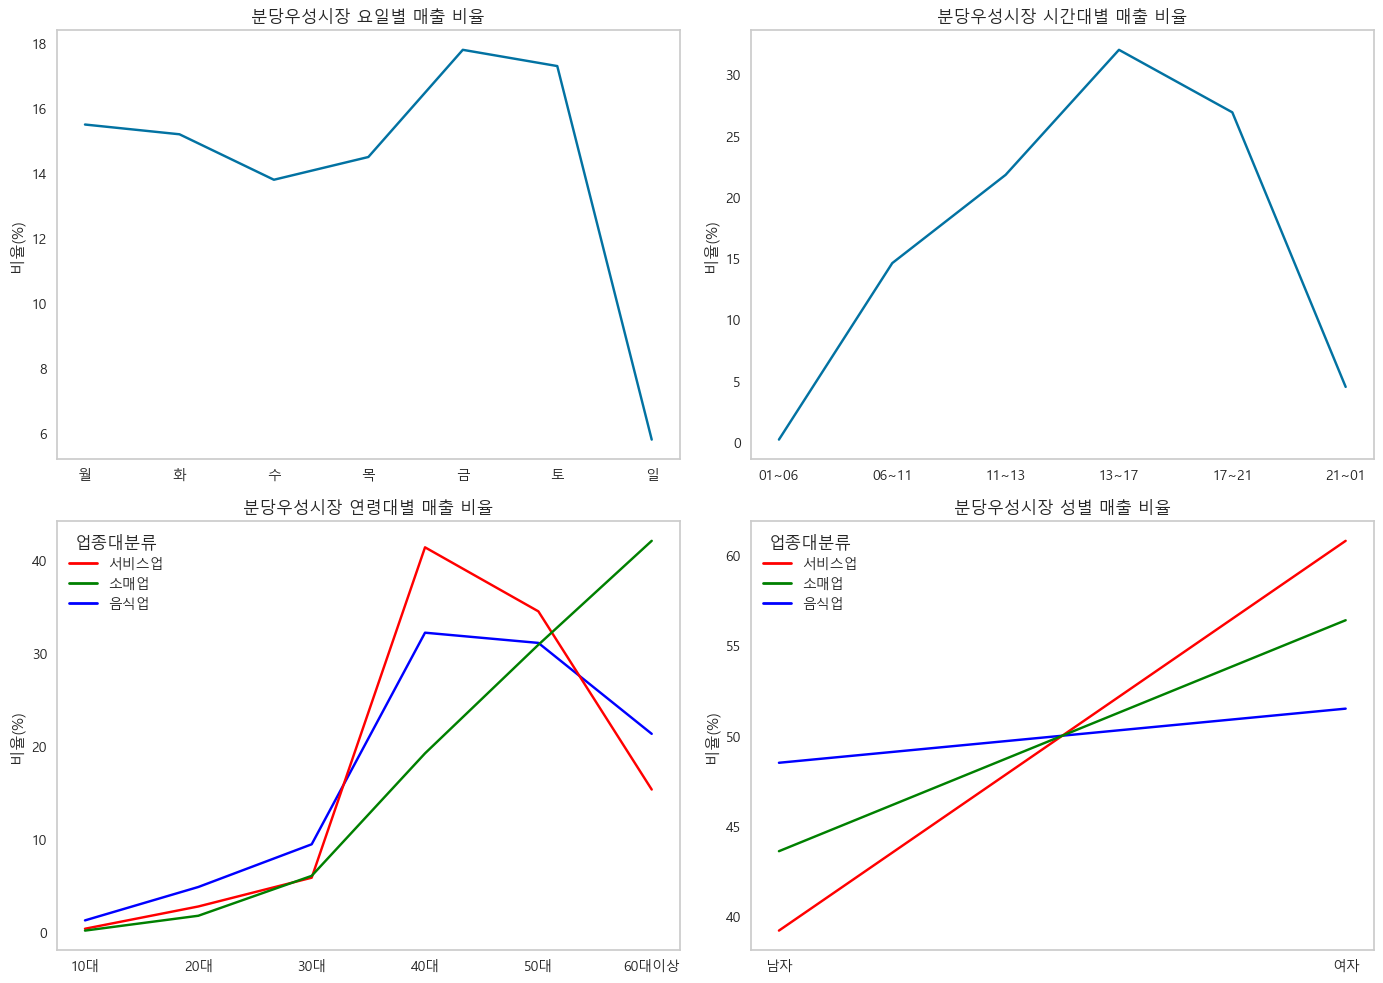

In [65]:
sn_commercial="서현 전통상권" #성남상권
commercial_name='분당우성시장' #상권명
commercial_type1="전통" #상권종류 (발달, 골목, 전통)
df_day=data_day.query("성남상권==@sn_commercial & 상권==@commercial_name & 종류==@commercial_type1").copy()
df_time=data_time.query("성남상권==@sn_commercial & 상권==@commercial_name & 종류==@commercial_type1").copy()
df_age_sex=data_age_sex.query("성남상권==@sn_commercial & 상권==@commercial_name & 종류==@commercial_type1").copy()

# 업종 색상 정의
industry_colors = {
    '서비스업': 'red',
    '소매업': 'green',
    '음식업': 'blue'
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2행 2열

# 평면화하여 index로 접근
axes = axes.flatten()

# df_day 요일별 선 그래프
df_day.loc[:, ['월', '화', '수', '목', '금', '토', '일']].T.plot(
    ax=axes[0], legend=False, title=f'{commercial_name} 요일별 매출 비율')
axes[0].set_ylabel('비율(%)')
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(['월', '화', '수', '목', '금', '토', '일'])
axes[0].grid()

# df_time 시간대별 선 그래프
df_time.loc[:, ['01~06', '06~11', '11~13', '13~17', '17~21', '21~01']].T.plot(
    ax=axes[1], legend=False, title=f'{commercial_name} 시간대별 매출 비율')
axes[1].set_ylabel('비율(%)')
axes[1].set_xticks(range(6))
axes[1].set_xticklabels(['01~06', '06~11', '11~13', '13~17', '17~21', '21~01'])
axes[1].grid()

# df_age_sex 연령별 선 그래프
for _, row in df_age_sex.iterrows():
    x = ['10대', '20대', '30대', '40대', '50대', '60대이상']
    y = row[x]
    color = industry_colors.get(row['업종'], 'black')
    axes[2].plot(x, y, color=color, label=row['업종'])

axes[2].set_title(f'{commercial_name} 연령대별 매출 비율')
axes[2].set_ylabel('비율(%)')
axes[2].grid()
axes[2].legend(
    handles=[plt.Line2D([0], [0], color=val, lw=2) for val in industry_colors.values()],
    labels=industry_colors.keys(),
    title="업종대분류",
    loc='upper left'
)

# df_age_sex 성별 선 그래프
for _, row in df_age_sex.iterrows():
    x = ['남자', '여자']
    y = row[x]
    color = industry_colors.get(row['업종'], 'black')
    axes[3].plot(x, y, color=color)

axes[3].set_title(f'{commercial_name} 성별 매출 비율')
axes[3].set_ylabel('비율(%)')
axes[3].grid()
axes[3].legend(
    handles=[plt.Line2D([0], [0], color=val, lw=2) for val in industry_colors.values()],
    labels=industry_colors.keys(),
    title="업종대분류",
    loc='upper left'
)

plt.tight_layout()
plt.show()


##  6-4) 미래타운제2종합시장 (서현 전통상권 – 군집3)

### <그림 20, 미래타운제2종합시장 상권 특성>

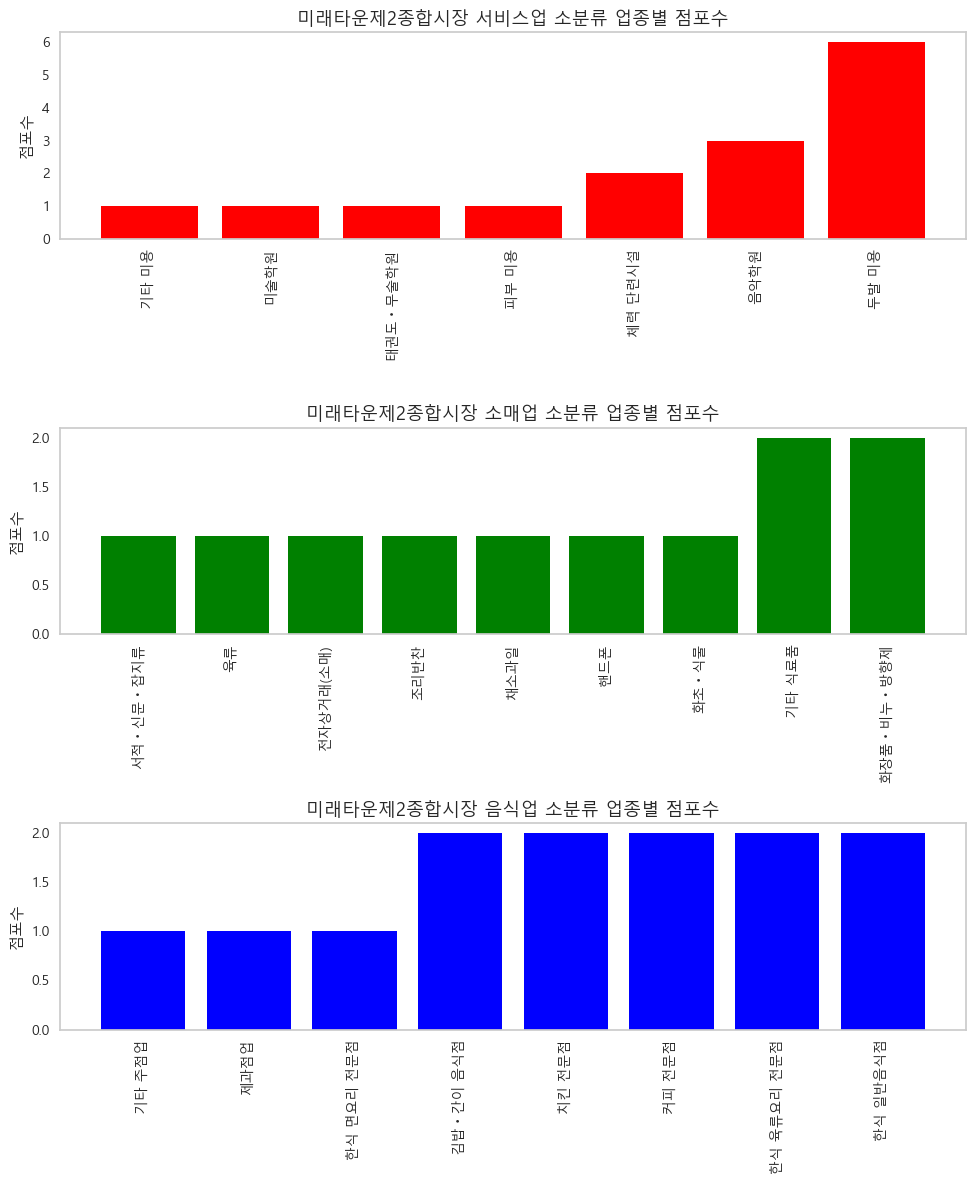

In [66]:
sn_commercial="서현 전통상권" #성남상권
commercial_name='미래타운제2종합시장' #상권명
commercial_type="전통시장" #상권종류 (발달상권, 골목상권, 전통시장)
quarter="2024년2분기"

df=data_small.query("성남상권==@sn_commercial & 상권명==@commercial_name & 상권종류==@commercial_type & 분기==@quarter").copy()
df=df.drop(columns=["성남상권","상권종류","분기","매출총액","매출건수"])
df=df.sort_values(by=["업종대분류","점포수"])

# 색상 매핑 딕셔너리
color_map = {
    "서비스업": "red",
    "소매업": "green",
    "음식업": "blue"
}

store_type = ["서비스업", "소매업", "음식업"]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=False)

for i, type_big in enumerate(store_type):
    temp = df[(df["업종대분류"] == type_big) & (df["점포수"] > 0)]
    axes[i].bar(temp["업종"], temp["점포수"], color=color_map[type_big])
    axes[i].set_title(f"{commercial_name} {type_big} 소분류 업종별 점포수", fontsize=13)
    axes[i].set_ylabel("점포수")
    axes[i].tick_params(axis='x', labelrotation=90)
    axes[i].grid()
plt.tight_layout()
plt.show()

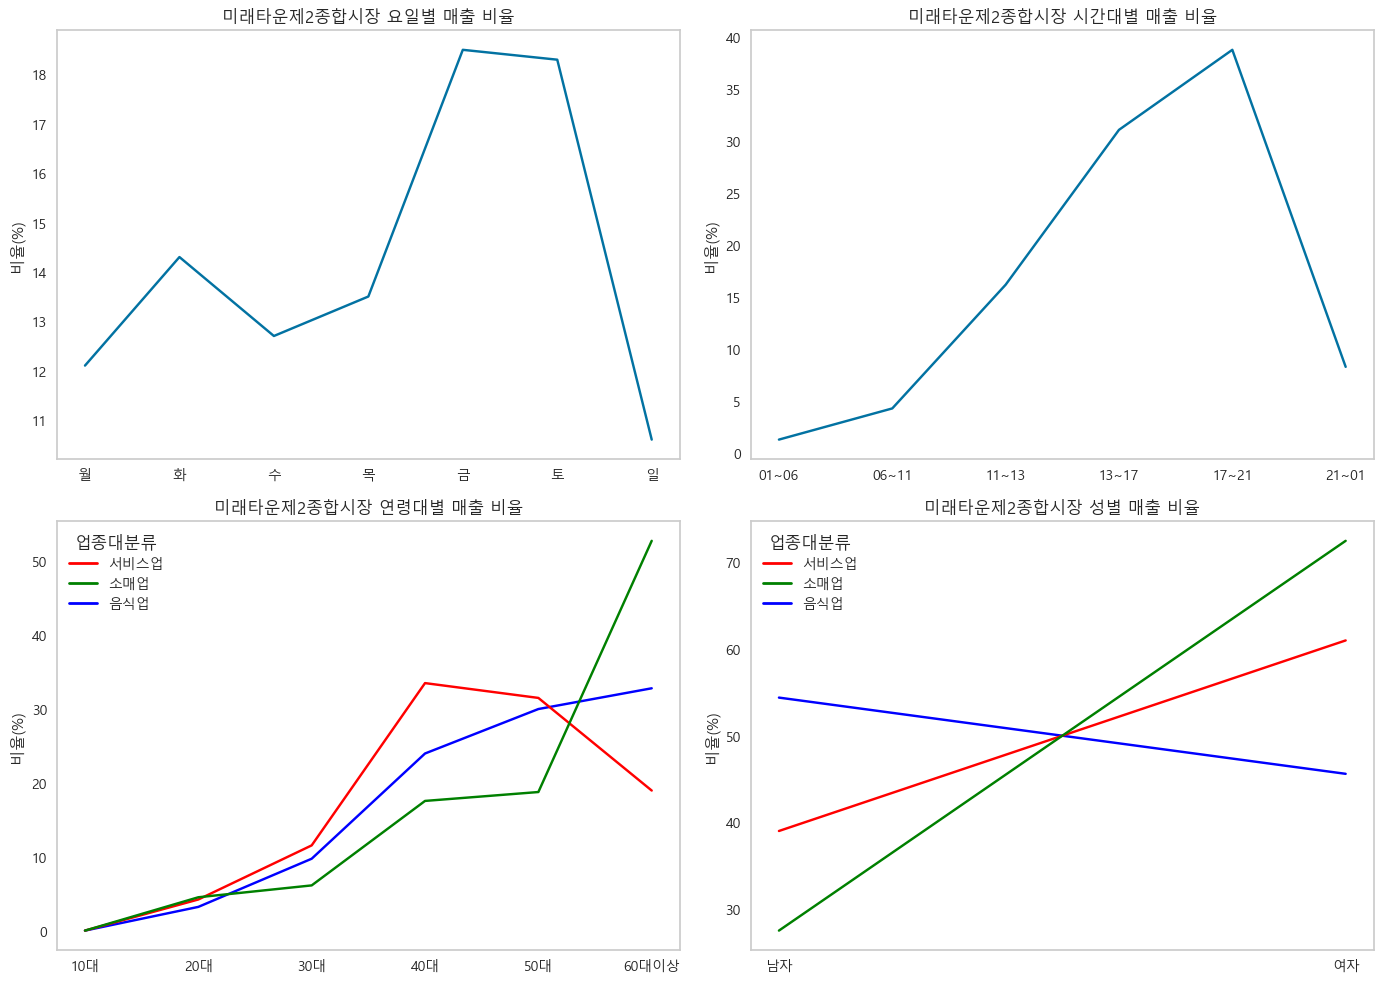

In [67]:
sn_commercial="서현 전통상권" #성남상권
commercial_name='미래타운제2종합시장' #상권명
commercial_type1="전통" #상권종류 (발달, 골목, 전통)
df_day=data_day.query("성남상권==@sn_commercial & 상권==@commercial_name & 종류==@commercial_type1").copy()
df_time=data_time.query("성남상권==@sn_commercial & 상권==@commercial_name & 종류==@commercial_type1").copy()
df_age_sex=data_age_sex.query("성남상권==@sn_commercial & 상권==@commercial_name & 종류==@commercial_type1").copy()

# 업종 색상 정의
industry_colors = {
    '서비스업': 'red',
    '소매업': 'green',
    '음식업': 'blue'
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2행 2열

# 평면화하여 index로 접근
axes = axes.flatten()

# df_day 요일별 선 그래프
df_day.loc[:, ['월', '화', '수', '목', '금', '토', '일']].T.plot(
    ax=axes[0], legend=False, title=f'{commercial_name} 요일별 매출 비율')
axes[0].set_ylabel('비율(%)')
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(['월', '화', '수', '목', '금', '토', '일'])
axes[0].grid()

# df_time 시간대별 선 그래프
df_time.loc[:, ['01~06', '06~11', '11~13', '13~17', '17~21', '21~01']].T.plot(
    ax=axes[1], legend=False, title=f'{commercial_name} 시간대별 매출 비율')
axes[1].set_ylabel('비율(%)')
axes[1].set_xticks(range(6))
axes[1].set_xticklabels(['01~06', '06~11', '11~13', '13~17', '17~21', '21~01'])
axes[1].grid()

# df_age_sex 연령별 선 그래프
for _, row in df_age_sex.iterrows():
    x = ['10대', '20대', '30대', '40대', '50대', '60대이상']
    y = row[x]
    color = industry_colors.get(row['업종'], 'black')
    axes[2].plot(x, y, color=color, label=row['업종'])

axes[2].set_title(f'{commercial_name} 연령대별 매출 비율')
axes[2].set_ylabel('비율(%)')
axes[2].grid()
axes[2].legend(
    handles=[plt.Line2D([0], [0], color=val, lw=2) for val in industry_colors.values()],
    labels=industry_colors.keys(),
    title="업종대분류",
    loc='upper left'
)

# df_age_sex 성별 선 그래프
for _, row in df_age_sex.iterrows():
    x = ['남자', '여자']
    y = row[x]
    color = industry_colors.get(row['업종'], 'black')
    axes[3].plot(x, y, color=color)

axes[3].set_title(f'{commercial_name} 성별 매출 비율')
axes[3].set_ylabel('비율(%)')
axes[3].grid()
axes[3].legend(
    handles=[plt.Line2D([0], [0], color=val, lw=2) for val in industry_colors.values()],
    labels=industry_colors.keys(),
    title="업종대분류",
    loc='upper left'
)

plt.tight_layout()
plt.show()


# ◦ 활용방안 및 기대효과

### <그림 21, 성남사랑 상품권 60대 이상 카드형, 지류형 결제량 비교>

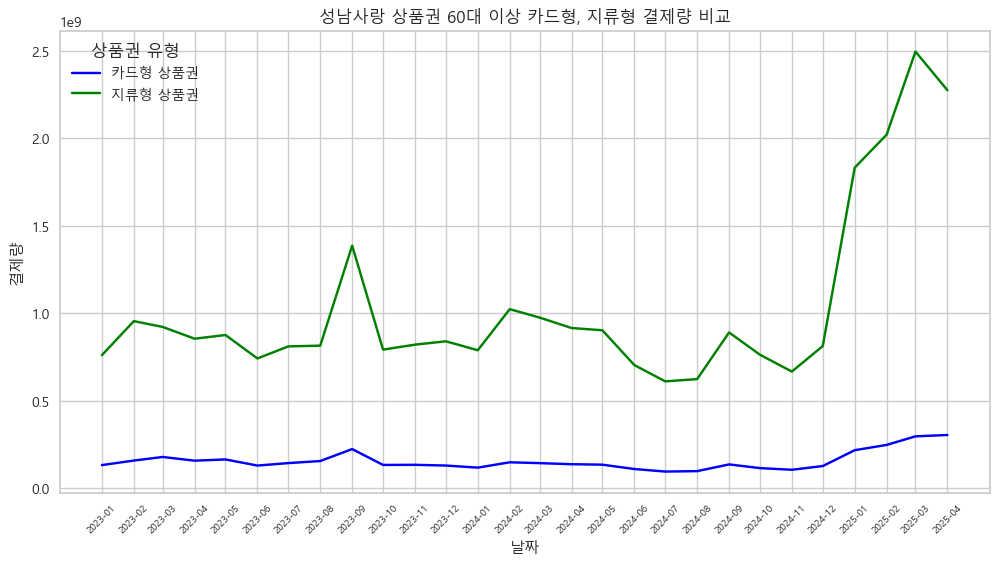

In [68]:
temp_2023=data_gift[data_gift['crtr_ym'] >= '2023-01-01'].reset_index(drop=True)
temp_60=temp_2023[["crtr_ym", "par_ag", "card_use_amt", "mbl_use_amt"]].copy()
temp_60=temp_60.query("par_ag==6").reset_index(drop=True)
temp_60=temp_60.groupby(["crtr_ym","par_ag"]).agg({"card_use_amt": "sum", "mbl_use_amt": "sum"}).reset_index()

plt.figure(figsize=(12, 6))

x_order = temp_60["crtr_ym"]
x_labels = [d.strftime('%Y-%m') for d in x_order]

plt.plot(temp_60['crtr_ym'], temp_60['card_use_amt'], label='카드형 상품권', color='blue')
plt.plot(temp_60['crtr_ym'], temp_60['mbl_use_amt'], label='지류형 상품권', color='green')

plt.xlabel('날짜')
plt.ylabel('결제량')
plt.title('성남사랑 상품권 60대 이상 카드형, 지류형 결제량 비교')
plt.legend(title='상품권 유형')
plt.xticks(ticks=x_order, labels=x_labels, rotation=45, fontsize=7)
plt.grid(True)
plt.show()